<a href="https://colab.research.google.com/github/shashikumar1998/Crop-Yield-Predition/blob/main/Data_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Pre-requisites and loading packages**

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [ ]:
!pip install -q findspark
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import libraries
import numpy as np
import pandas as pd
from pyspark.sql.functions import *
from pyspark.sql.types import StringType,BooleanType,DateType
import matplotlib.pyplot as plt
import seaborn as sns

**Crop Yield Data**

Load dataset

In [ ]:
#Crop yield dataset - Pulling from the source
cropYield = pd.read_csv("/content/drive/Shareddrives/GWAR_datasets/raw_cropyield_data.csv")
del cropYield[cropYield.columns[0]]
#display crop yield data
cropYield

longitude   latitude  crop_flow_lb_s                   datetime  \
0      -85.372824  42.408276            3.29  2013-07-24 19:20:04+00:00   
1      -85.372838  42.408288            2.89  2013-07-24 19:20:03+00:00   
2      -85.372847  42.408296            2.89  2013-07-24 19:20:02+00:00   
3      -85.372855  42.408301            3.69  2013-07-24 19:20:01+00:00   
4      -85.372855  42.408304            3.39  2013-07-24 19:20:00+00:00   
...           ...        ...             ...                        ...   
767821 -85.375763  42.408524            0.00  1996-10-29 00:12:17+00:00   
767822 -85.375763  42.408520            0.00  1996-10-29 00:12:14+00:00   
767823 -85.375771  42.408520            0.00  1996-10-29 00:12:09+00:00   
767824 -85.375771  42.408524            0.00  1996-10-29 00:12:08+00:00   
767825 -85.375771  42.408520            0.00  1996-10-29 00:12:06+00:00   

        duration_  distance_in  swth_wdth_in  moisture  status  pass_num  \
0               1         56.0         180.0       6.6     0.0       141   
1               1         47.0         180.0       6.6     0.0       141   
2               1         38.0         180.0       6.6     0.0       141   
3               1         18.0         180.0       6.6     0.0       141   
4               1         39.0         180.0       6.6     0.0       141   
...           ...          ...           ...       ...     ...       ...   
767821          1          9.0          90.0       5.0    33.0         1   
767822          1          3.0          90.0       5.0    33.0         1   
767823          1          9.0          90.0       5.0    33.0         1   
767824          1          9.0          90.0       5.0    33.0         1   
767825          2         24.0          90.0       5.0    33.0         1   

        serial_number          field     dataset             product  \
0                5648  F1: Lysimeter        L1:   Wheat (Sft Rd Wtr)   
1                5648  F1: Lysimeter        L1:   Wheat (Sft Rd Wtr)   
2                5648  F1: Lysimeter        L1:   Wheat (Sft Rd Wtr)   
3                5648  F1: Lysimeter        L1:   Wheat (Sft Rd Wtr)   
4                5648  F1: Lysimeter        L1:   Wheat (Sft Rd Wtr)   
...               ...            ...         ...                 ...   
767821         960462      F32: T4R6  L1: EAST66                Corn   
767822         960462      F32: T4R6  L1: EAST66                Corn   
767823         960462      F32: T4R6  L1: EAST66                Corn   
767824         960462      F32: T4R6  L1: EAST66                Corn   
767825         960462      F32: T4R6  L1: EAST66                Corn   

        elevation_ft  
0              953.5  
1              953.5  
2              953.5  
3              953.5  
4              953.5  
...              ...  
767821         660.3  
767822         660.6  
767823         660.6  
767824         660.9  
767825         660.9  

[767826 rows x 15 columns]

**Data Cleansing**


In [ ]:
#changing datatypes for crop yield dataset
cropYield["datetime"] = pd.to_datetime(cropYield["datetime"])
for col in ['field', 'dataset', 'product']:
    cropYield[col] = cropYield[col].astype('category')

Data exploration

In [ ]:
cropYield.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767826 entries, 0 to 767825
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   longitude       767826 non-null  float64            
 1   latitude        767826 non-null  float64            
 2   crop_flow_lb_s  767826 non-null  float64            
 3   datetime        767826 non-null  datetime64[ns, UTC]
 4   duration_       767826 non-null  int64              
 5   distance_in     767826 non-null  float64            
 6   swth_wdth_in    767826 non-null  float64            
 7   moisture        767826 non-null  float64            
 8   status          738576 non-null  float64            
 9   pass_num        767826 non-null  int64              
 10  serial_number   767826 non-null  int64              
 11  field           767826 non-null  category           
 12  dataset         767826 non-null  category           
 13  product       

In [ ]:
cropYield.describe()

longitude       latitude  crop_flow_lb_s      duration_  \
count  767826.000000  767826.000000   767826.000000  767826.000000   
mean      -85.371253      42.410467        4.385266       1.000046   
std         0.002455       0.002434        3.518088       0.007307   
min       -85.377495      42.403019        0.000000       1.000000   
25%       -85.372307      42.408388        2.200000       1.000000   
50%       -85.370759      42.410198        3.400000       1.000000   
75%       -85.369316      42.412493        5.477000       1.000000   
max       -85.367924      42.415367       48.740000       3.000000   

         distance_in   swth_wdth_in       moisture         status  \
count  767826.000000  767826.000000  767826.000000  738576.000000   
mean       65.898031     151.341804      15.056510      11.078657   
std        18.862594      39.114134       7.495497      15.024646   
min         0.000000      12.000000      -4.600000       0.000000   
25%        55.000000     120.000000      12.500000       1.000000   
50%        66.000000     180.000000      14.800000       1.000000   
75%        78.000000     180.000000      17.580000      33.000000   
max       482.000000     180.000000      40.000000      33.000000   

            pass_num  serial_number   elevation_ft  
count  767826.000000   7.678260e+05  767826.000000  
mean       10.603598   1.735062e+08     920.257317  
std        13.708727   5.624374e+08      89.353645  
min         1.000000   5.648000e+03     536.300000  
25%         3.000000   5.648000e+03     858.700000  
50%         7.000000   5.648000e+03     951.000000  
75%        12.000000   9.604620e+05     980.500000  
max       149.000000   2.000140e+09    1158.500000

Exploring Crop Yield Data

<ipython-input-13-24c3a1977e63>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = cropYield.corr()


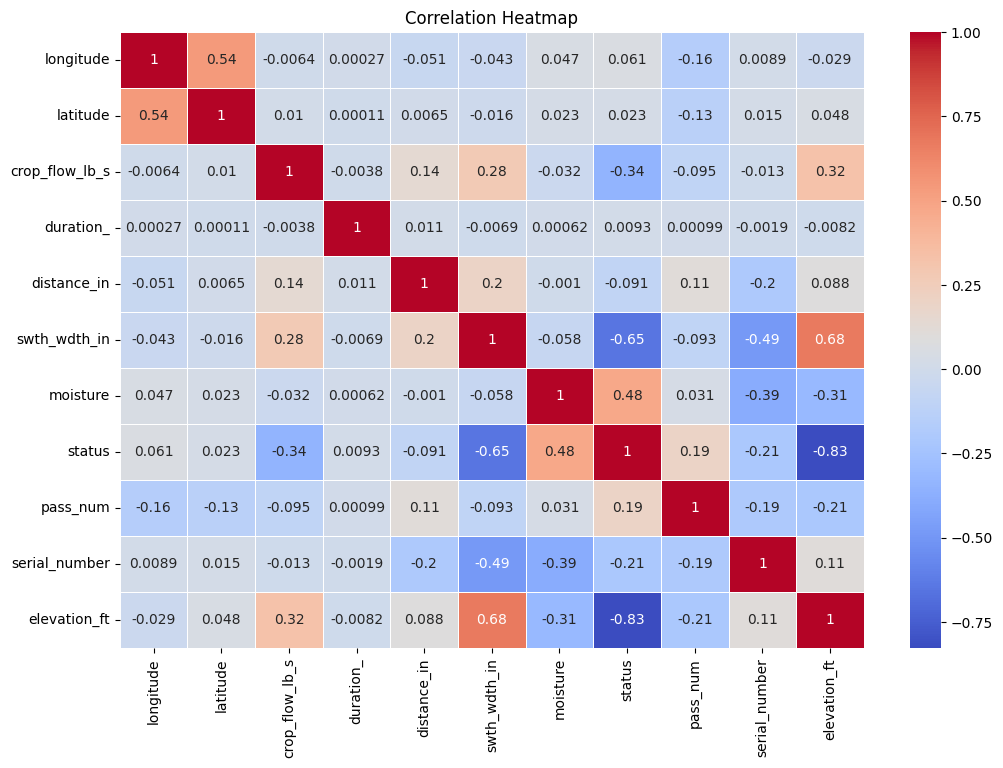

In [ ]:
correlation_matrix = cropYield.corr()
plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

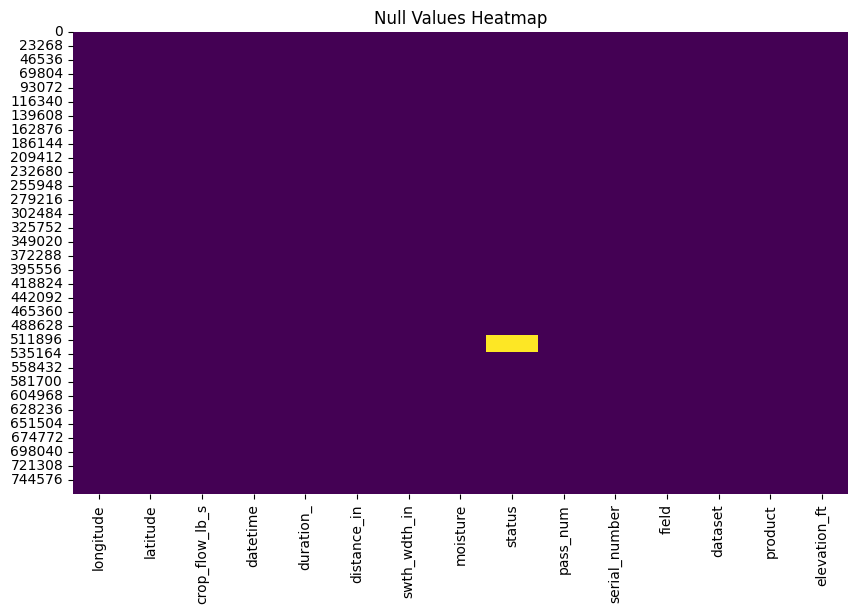

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(cropYield.isnull(), cbar=False, cmap='viridis')
plt.title('Null Values Heatmap')
plt.show()

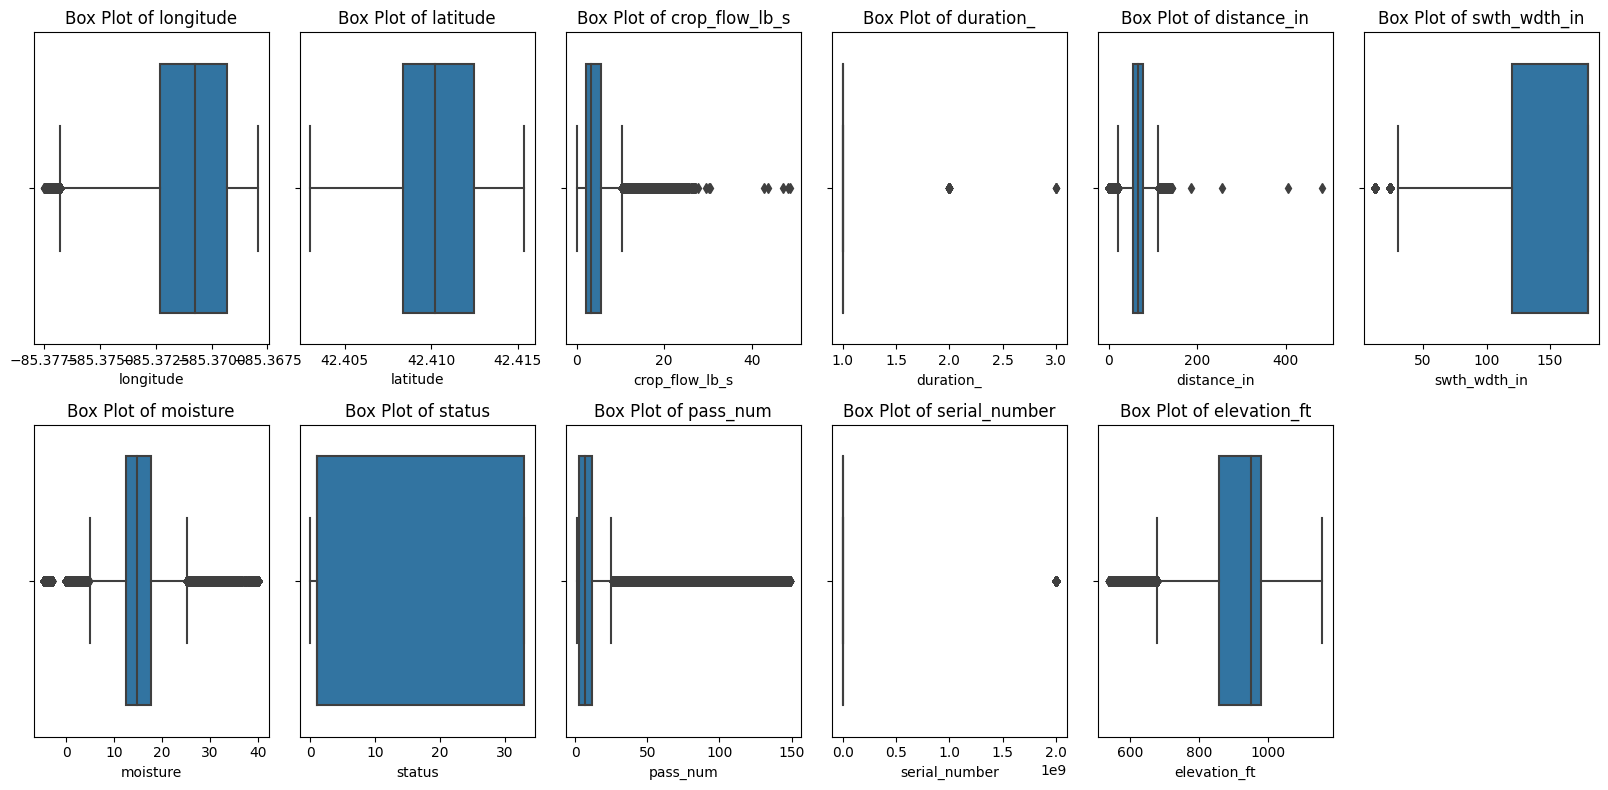

In [ ]:
# Separate numeric and categorical columns
numeric_columns = cropYield.select_dtypes(include=['number']).columns
categorical_columns = cropYield.select_dtypes(include=['object']).columns

# Create box plots for numeric columns
plt.figure(figsize=(16, 8))
for i, column in enumerate(numeric_columns):
    plt.subplot(2, (len(numeric_columns)//2)+1, i+1)
    sns.boxplot(x=cropYield[column])
    plt.title(f'Box Plot of {column}')

plt.tight_layout()
plt.show()

Data Cleansing- Handling incomplete and missing data



In [ ]:
#Find missing values
cropYield.isna().sum()

longitude             0
latitude              0
crop_flow_lb_s        0
datetime              0
duration_             0
distance_in           0
swth_wdth_in          0
moisture              0
status            29250
pass_num              0
serial_number         0
field                 0
dataset               0
product               0
elevation_ft          0
dtype: int64

For the crop yield data, there are 29250 values which are nulls and can be hadled by mean imputation.

In [ ]:
#mean imputation for status column
cropYield['status'].fillna(cropYield['status'].mean(), inplace=True)
#Check if the mean imputation fixed the missing values
cropYield.isna().sum()

longitude         0
latitude          0
crop_flow_lb_s    0
datetime          0
duration_         0
distance_in       0
swth_wdth_in      0
moisture          0
status            0
pass_num          0
serial_number     0
field             0
dataset           0
product           0
elevation_ft      0
dtype: int64

Data Cleansing: Handling noisy data

In [ ]:
cropYield.describe()

longitude       latitude  crop_flow_lb_s      duration_  \
count  767826.000000  767826.000000   767826.000000  767826.000000   
mean      -85.371253      42.410467        4.385266       1.000046   
std         0.002455       0.002434        3.518088       0.007307   
min       -85.377495      42.403019        0.000000       1.000000   
25%       -85.372307      42.408388        2.200000       1.000000   
50%       -85.370759      42.410198        3.400000       1.000000   
75%       -85.369316      42.412493        5.477000       1.000000   
max       -85.367924      42.415367       48.740000       3.000000   

         distance_in   swth_wdth_in       moisture         status  \
count  767826.000000  767826.000000  767826.000000  767826.000000   
mean       65.898031     151.341804      15.056510      11.078657   
std        18.862594      39.114134       7.495497      14.735689   
min         0.000000      12.000000      -4.600000       0.000000   
25%        55.000000     120.000000      12.500000       1.000000   
50%        66.000000     180.000000      14.800000       1.000000   
75%        78.000000     180.000000      17.580000      33.000000   
max       482.000000     180.000000      40.000000      33.000000   

            pass_num  serial_number   elevation_ft  
count  767826.000000   7.678260e+05  767826.000000  
mean       10.603598   1.735062e+08     920.257317  
std        13.708727   5.624374e+08      89.353645  
min         1.000000   5.648000e+03     536.300000  
25%         3.000000   5.648000e+03     858.700000  
50%         7.000000   5.648000e+03     951.000000  
75%        12.000000   9.604620e+05     980.500000  
max       149.000000   2.000140e+09    1158.500000

We can see that all the values are in the expected range and hence there is no noisy data to clean.

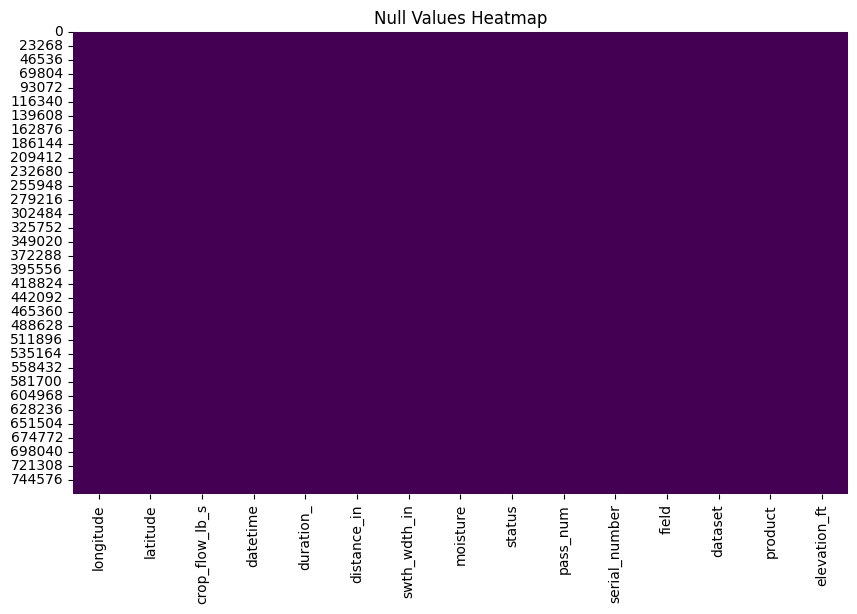

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(cropYield.isnull(), cbar=False, cmap='viridis')
plt.title('Null Values Heatmap')
plt.show()

Data Cleaning: Handling of Inconsistent Data

In [ ]:
cropYield.columns

Index(['longitude', 'latitude', 'crop_flow_lb_s', 'datetime', 'duration_',
       'distance_in', 'swth_wdth_in', 'moisture', 'status', 'pass_num',
       'serial_number', 'field', 'dataset', 'product', 'elevation_ft'],
      dtype='object')

AttributeError: ignored

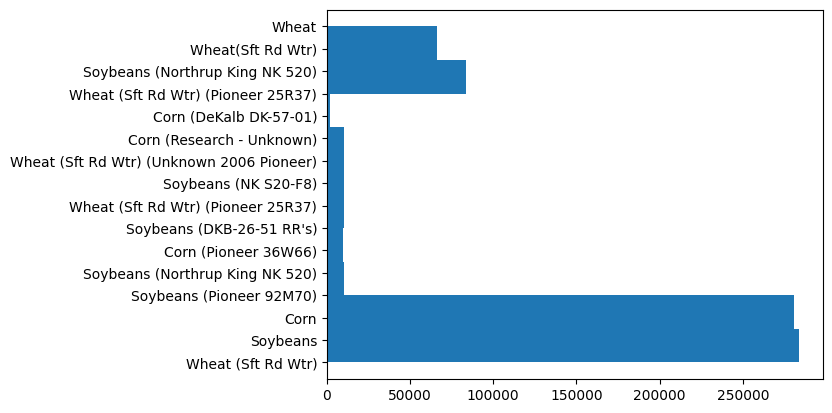

In [ ]:
cropYield['product'].hist(column='Value', orientation="horizontal")

In [ ]:
#Binning the product column into 3 values: Corn, soybeans and Wheat since there were column values
cropYield['product'] = cropYield['product'].str.strip()
cropYield.loc[cropYield['product'].str.contains('Wheat', case=False), 'product'] = 'Wheat'
cropYield.loc[cropYield['product'].str.contains('Soybeans', case=False), 'product'] = 'Soybeans'
cropYield.loc[cropYield['product'].str.contains('Corn', case=False), 'product'] = 'Corn'
cropYield['product'].value_counts()

Corn        301250
Wheat       234494
Soybeans    232082
Name: product, dtype: int64

AttributeError: ignored

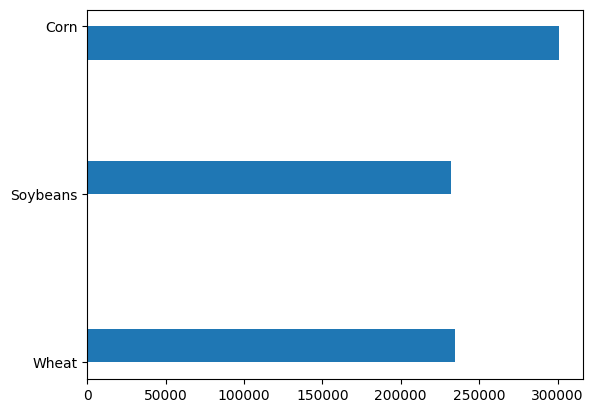

In [ ]:
#Displaying the above using histogram
cropYield['product'].hist(column='Value', orientation="horizontal")

In [ ]:
cropYield

longitude   latitude  crop_flow_lb_s                  datetime  \
0      -85.372824  42.408276            3.29 2013-07-24 19:20:04+00:00   
1      -85.372838  42.408288            2.89 2013-07-24 19:20:03+00:00   
2      -85.372847  42.408296            2.89 2013-07-24 19:20:02+00:00   
3      -85.372855  42.408301            3.69 2013-07-24 19:20:01+00:00   
4      -85.372855  42.408304            3.39 2013-07-24 19:20:00+00:00   
...           ...        ...             ...                       ...   
767821 -85.375763  42.408524            0.00 1996-10-29 00:12:17+00:00   
767822 -85.375763  42.408520            0.00 1996-10-29 00:12:14+00:00   
767823 -85.375771  42.408520            0.00 1996-10-29 00:12:09+00:00   
767824 -85.375771  42.408524            0.00 1996-10-29 00:12:08+00:00   
767825 -85.375771  42.408520            0.00 1996-10-29 00:12:06+00:00   

        duration_  distance_in  swth_wdth_in  moisture  status  pass_num  \
0               1         56.0         180.0       6.6     0.0       141   
1               1         47.0         180.0       6.6     0.0       141   
2               1         38.0         180.0       6.6     0.0       141   
3               1         18.0         180.0       6.6     0.0       141   
4               1         39.0         180.0       6.6     0.0       141   
...           ...          ...           ...       ...     ...       ...   
767821          1          9.0          90.0       5.0    33.0         1   
767822          1          3.0          90.0       5.0    33.0         1   
767823          1          9.0          90.0       5.0    33.0         1   
767824          1          9.0          90.0       5.0    33.0         1   
767825          2         24.0          90.0       5.0    33.0         1   

        serial_number          field     dataset product  elevation_ft  
0                5648  F1: Lysimeter        L1:    Wheat         953.5  
1                5648  F1: Lysimeter        L1:    Wheat         953.5  
2                5648  F1: Lysimeter        L1:    Wheat         953.5  
3                5648  F1: Lysimeter        L1:    Wheat         953.5  
4                5648  F1: Lysimeter        L1:    Wheat         953.5  
...               ...            ...         ...     ...           ...  
767821         960462      F32: T4R6  L1: EAST66    Corn         660.3  
767822         960462      F32: T4R6  L1: EAST66    Corn         660.6  
767823         960462      F32: T4R6  L1: EAST66    Corn         660.6  
767824         960462      F32: T4R6  L1: EAST66    Corn         660.9  
767825         960462      F32: T4R6  L1: EAST66    Corn         660.9  

[767826 rows x 15 columns]

The rest of the column values in the crop yield dataset look good and hence is ready for transformation


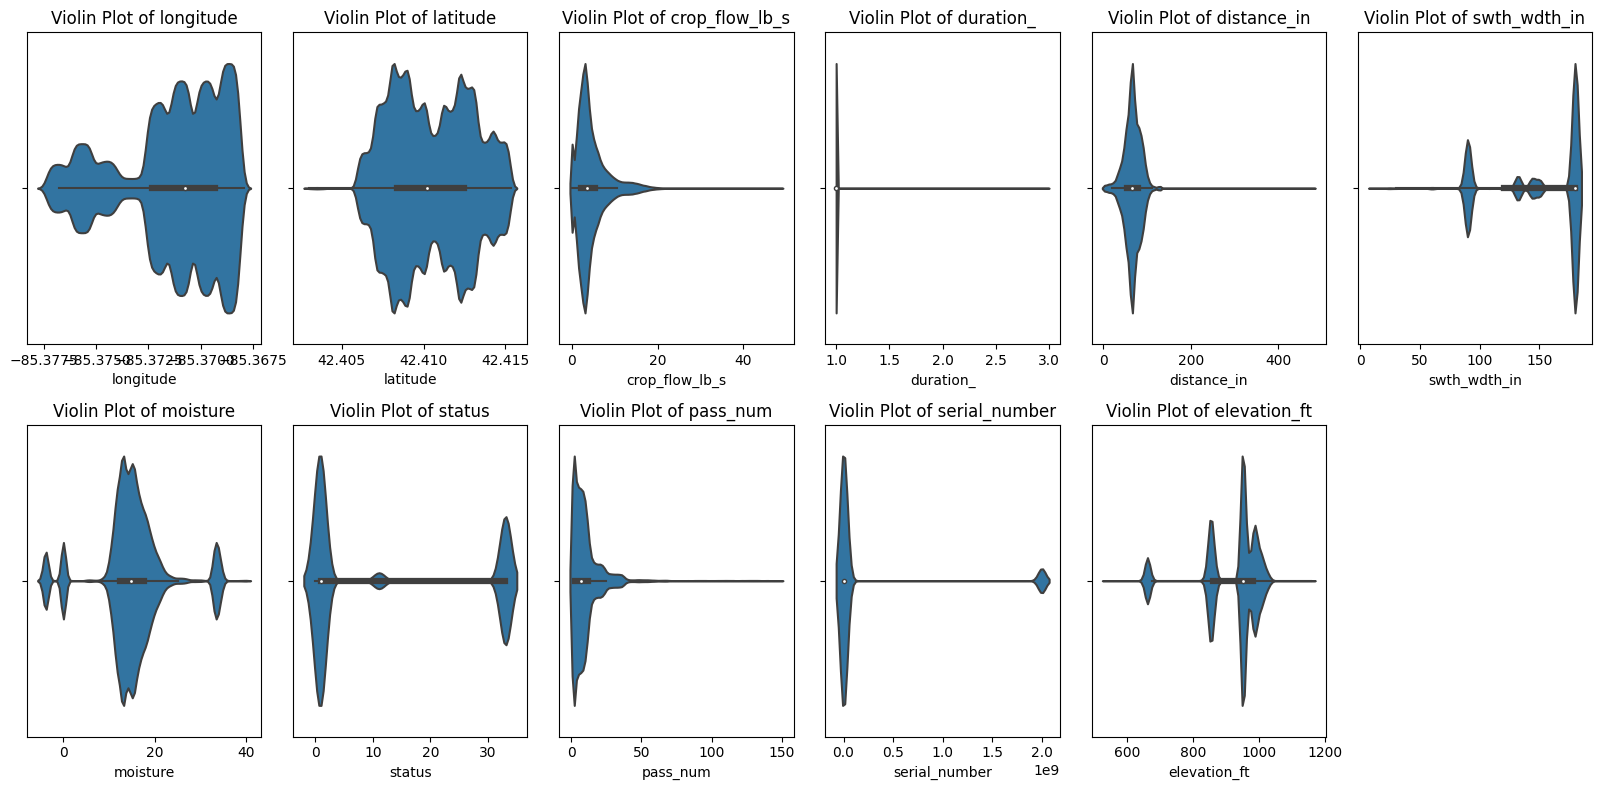

In [ ]:
# Separate numeric and categorical columns
numeric_columns = cropYield.select_dtypes(include=['number']).columns
categorical_columns = cropYield.select_dtypes(include=['object']).columns

# Create violin plots for numeric columns
plt.figure(figsize=(16, 8))
for i, column in enumerate(numeric_columns):
    plt.subplot(2, (len(numeric_columns)//2)+1, i+1)
    sns.violinplot(x=cropYield[column])
    plt.title(f'Violin Plot of {column}')

plt.tight_layout()
plt.show()

**Location Data**

Load dataset

In [ ]:
#Load Location dataset - Pulling from the shared drive
location = pd.read_csv('/content/drive/Shareddrives/GWAR_datasets/raw_location_data.csv')
del location[location.columns[0]]
location

longitude   latitude           name     state        country
0      -85.372875  42.410102  Ross Township  Michigan  United States
1      -85.373105  42.409535  Ross Township  Michigan  United States
2      -85.373105  42.409618  Ross Township  Michigan  United States
3      -85.373208  42.408202  Ross Township  Michigan  United States
4      -85.373358  42.409088  Ross Township  Michigan  United States
...           ...        ...            ...       ...            ...
678406 -85.375923  42.408405  Ross Township  Michigan  United States
678407 -85.376091  42.408474  Ross Township  Michigan  United States
678408 -85.375862  42.408291  Ross Township  Michigan  United States
678409 -85.375381  42.408783  Ross Township  Michigan  United States
678410 -85.375671  42.409035  Ross Township  Michigan  United States

[678411 rows x 5 columns]

Data exploration

In [ ]:
location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678411 entries, 0 to 678410
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   longitude  678411 non-null  float64
 1   latitude   678411 non-null  float64
 2   name       678411 non-null  object 
 3   state      678411 non-null  object 
 4   country    678411 non-null  object 
dtypes: float64(2), object(3)
memory usage: 25.9+ MB


From above, we can see that the datatypes are consistent to what is expected and hence we do not have to change it

In [ ]:
location.describe()

longitude       latitude
count  678411.000000  678411.000000
mean      -85.371264      42.410470
std         0.002456       0.002441
min       -85.377495      42.403019
25%       -85.372335      42.408394
50%       -85.370770      42.410187
75%       -85.369322      42.412498
max       -85.367924      42.415367

Since there are only 2 continuous features, we go the 2 columns statistical description

**Data Cleansing**

Data Cleaning: Handling of Incomplete & Missing Data


In [ ]:
#Find missing values
location.isna().sum()

longitude    0
latitude     0
name         0
state        0
country      0
dtype: int64

<ipython-input-30-3c2c1bbf31f0>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = location.corr()


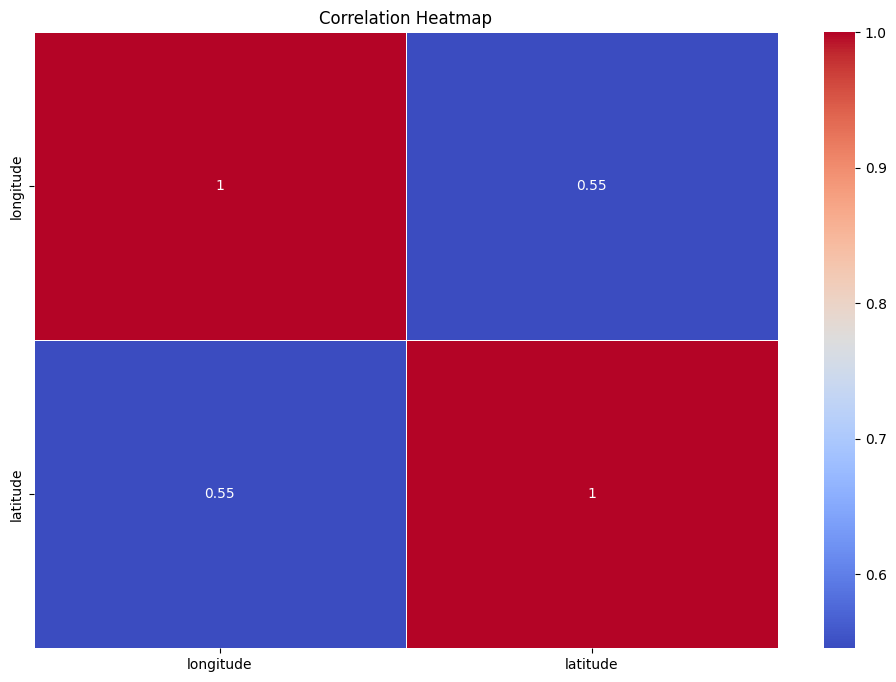

In [ ]:
correlation_matrix = location.corr()
plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

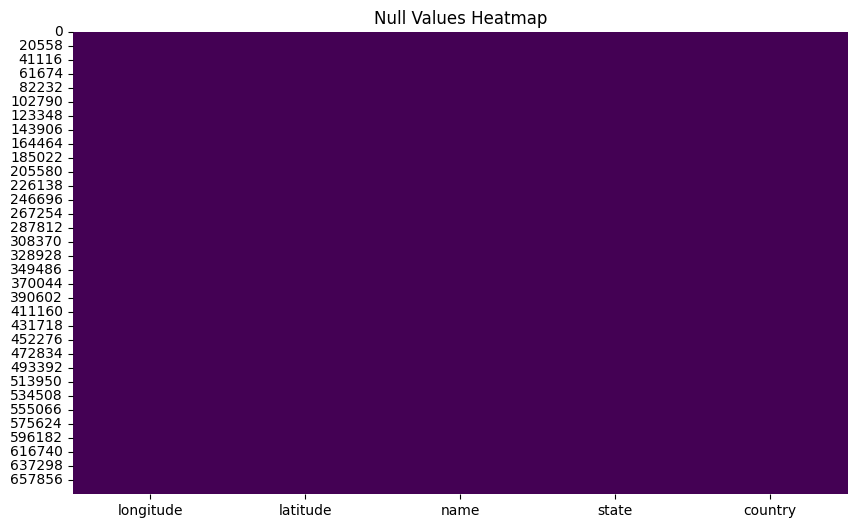

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(location.isnull(), cbar=False, cmap='viridis')
plt.title('Null Values Heatmap')
plt.show()

We can see that there is no missing data.

Data Cleaning: Handling of Noisy Data

In [ ]:
location['name'].value_counts()

Ross Township    678411
Name: name, dtype: int64

In [ ]:
location['state'].value_counts()

Michigan    678411
Name: state, dtype: int64

In [ ]:
location['country'].value_counts()

United States    678411
Name: country, dtype: int64

Data Cleaning: Handling of Inconsistent Data

<Axes: >

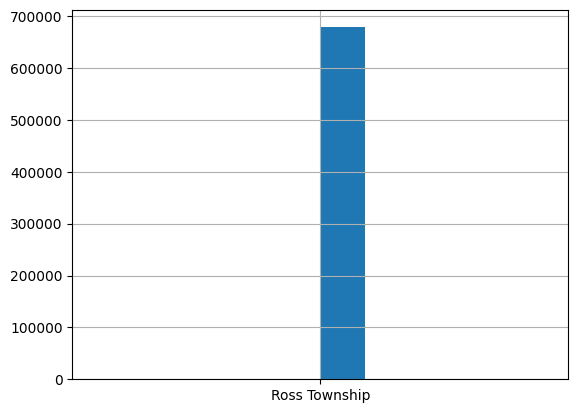

In [ ]:
#Displaying the data for finding data inconsistencies using histogram
location['name'].hist()

<Axes: >

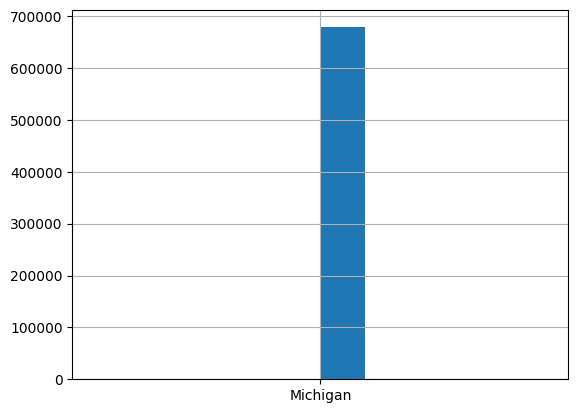

In [ ]:
#Displaying the data for finding data inconsistencies using histogram
location['state'].hist()

<Axes: >

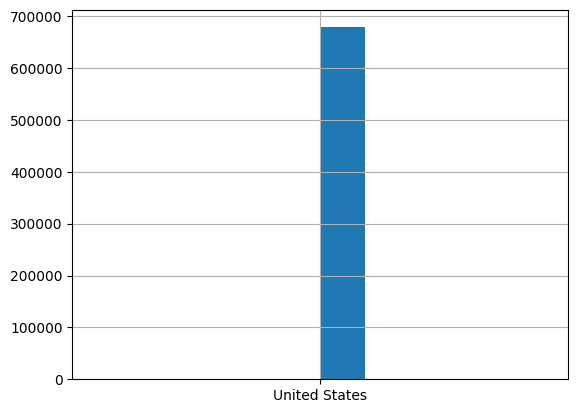

In [ ]:
#Displaying the data for finding data inconsistencies using histogram
location['country'].hist()

We can see that there are no data inconsistencies

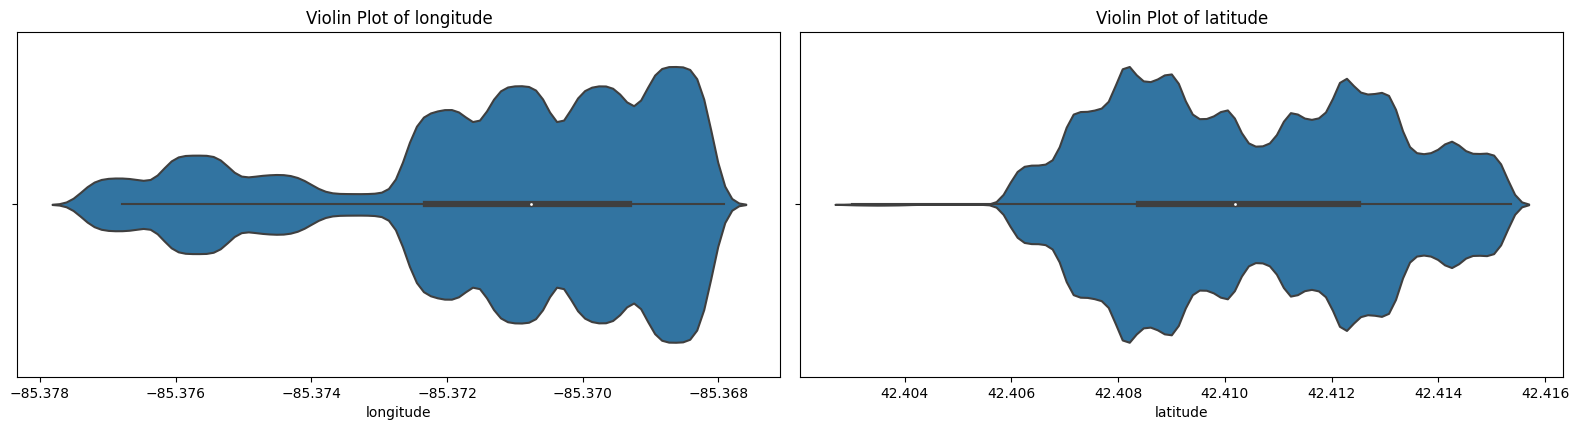

In [ ]:
# Separate numeric and categorical columns
numeric_columns = location.select_dtypes(include=['number']).columns
categorical_columns = location.select_dtypes(include=['object']).columns

# Create violin plots for numeric columns
plt.figure(figsize=(16, 8))
for i, column in enumerate(numeric_columns):
    plt.subplot(2, (len(numeric_columns)//2)+1, i+1)
    sns.violinplot(x=cropYield[column])
    plt.title(f'Violin Plot of {column}')

plt.tight_layout()
plt.show()

**Weather dataset**

In [ ]:
#Load weather dataset - Pulling from the shared drive
weather = pd.read_csv('/content/drive/Shareddrives/GWAR_datasets/raw_weather_data.csv')
del weather[weather.columns[0]]
weather

dt_iso  timezone      city_name        lat  \
0       1995-01-01 00:00:00 +0000 UTC    -18000  Ross Township  40.536772   
1       1995-01-01 01:00:00 +0000 UTC    -18000  Ross Township  40.536772   
2       1995-01-01 02:00:00 +0000 UTC    -18000  Ross Township  40.536772   
3       1995-01-01 03:00:00 +0000 UTC    -18000  Ross Township  40.536772   
4       1995-01-01 04:00:00 +0000 UTC    -18000  Ross Township  40.536772   
...                               ...       ...            ...        ...   
275163  2023-10-30 19:00:00 +0000 UTC    -14400  Ross Township  40.536772   
275164  2023-10-30 20:00:00 +0000 UTC    -14400  Ross Township  40.536772   
275165  2023-10-30 21:00:00 +0000 UTC    -14400  Ross Township  40.536772   
275166  2023-10-30 22:00:00 +0000 UTC    -14400  Ross Township  40.536772   
275167  2023-10-30 23:00:00 +0000 UTC    -14400  Ross Township  40.536772   

              lon    temp  visibility  dew_point  feels_like  temp_min  ...  \
0      -80.019956  278.57      1600.0     277.83      276.47    277.92  ...   
1      -80.019956  278.92         NaN     278.33      276.47    278.35  ...   
2      -80.019956  279.08         NaN     278.79      276.58    278.60  ...   
3      -80.019956  279.30         NaN     278.86      276.91    278.87  ...   
4      -80.019956  279.29         NaN     278.85      276.99    278.90  ...   
...           ...     ...         ...        ...         ...       ...  ...   
275163 -80.019956  280.57         NaN     279.67      279.54    279.57  ...   
275164 -80.019956  280.34         NaN     279.29      280.34    279.57  ...   
275165 -80.019956  280.22         NaN     279.17      279.66    279.21  ...   
275166 -80.019956  279.78         NaN     278.57      277.84    278.46  ...   
275167 -80.019956  278.93         NaN     277.58      276.83    277.90  ...   

        wind_gust  rain_1h  rain_3h  snow_1h  snow_3h  clouds_all  weather_id  \
0             NaN      NaN      NaN      NaN      NaN         100         741   
1             NaN     0.12      NaN      NaN      NaN         100         500   
2             NaN      NaN      NaN      NaN      NaN         100         804   
3             NaN      NaN      NaN      NaN      NaN         100         804   
4             NaN      NaN      NaN      NaN      NaN         100         804   
...           ...      ...      ...      ...      ...         ...         ...   
275163       2.68     1.01      NaN      NaN      NaN         100         501   
275164       2.68     0.45      NaN      NaN      NaN         100         500   
275165       4.92     0.85      NaN      NaN      NaN         100         500   
275166       5.81      NaN     0.56      NaN      NaN         100         500   
275167       5.36     0.25      NaN      NaN      NaN          92         500   

        weather_main  weather_description  weather_icon  
0                Fog                  fog           50n  
1               Rain           light rain           10n  
2             Clouds      overcast clouds           04n  
3             Clouds      overcast clouds           04n  
4             Clouds      overcast clouds           04n  
...              ...                  ...           ...  
275163          Rain        moderate rain           10d  
275164          Rain           light rain           10d  
275165          Rain           light rain           10d  
275166          Rain           light rain           10d  
275167          Rain           light rain           10n  

[275168 rows x 27 columns]

Data exploration

In [ ]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275168 entries, 0 to 275167
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               275168 non-null  object 
 1   timezone             275168 non-null  int64  
 2   city_name            275168 non-null  object 
 3   lat                  275168 non-null  float64
 4   lon                  275168 non-null  float64
 5   temp                 275168 non-null  float64
 6   visibility           245856 non-null  float64
 7   dew_point            275167 non-null  float64
 8   feels_like           275168 non-null  float64
 9   temp_min             275168 non-null  float64
 10  temp_max             275168 non-null  float64
 11  pressure             275168 non-null  int64  
 12  sea_level            0 non-null       float64
 13  grnd_level           0 non-null       float64
 14  humidity             275168 non-null  int64  
 15  wind_speed       

**Data Cleansing**

Data Cleaning: Handling of Incomplete & Missing Data

In [ ]:
#Find missing values
weather.isna().sum()

dt_iso                      0
timezone                    0
city_name                   0
lat                         0
lon                         0
temp                        0
visibility              29312
dew_point                   1
feels_like                  0
temp_min                    0
temp_max                    0
pressure                    0
sea_level              275168
grnd_level             275168
humidity                    0
wind_speed                  0
wind_deg                    0
wind_gust              226848
rain_1h                227159
rain_3h                275132
snow_1h                265022
snow_3h                275168
clouds_all                  0
weather_id                  0
weather_main                0
weather_description         0
weather_icon                0
dtype: int64

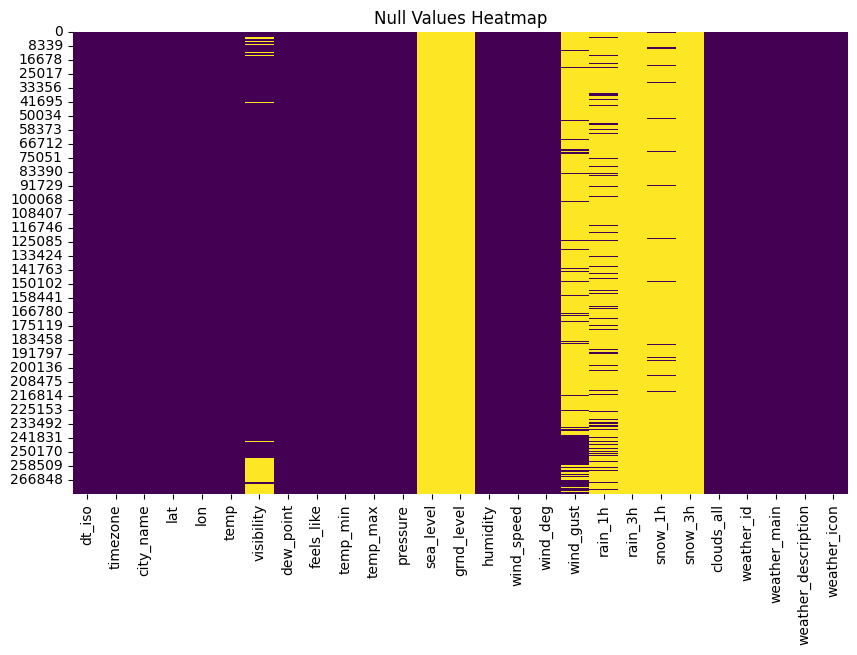

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(weather.isnull(), cbar=False, cmap='viridis')
plt.title('Null Values Heatmap')
plt.show()

From above we can see that columns: visibility, dew_point, sea_level, grnd_level, wind_gust, rain_1h, rain_3h, snow_1h, snow_3h.

It is recommended that if the nan percentage is more than 80%, we should drop the columns. For this dataset, there are a total of 275168 entries for which 80% will be 220134. Hence, we can drop columns: sea_level, grnd_level, wind_gust, rain_1h, rain_3h, snow_1h, snow_3h

In [ ]:
#dropping the columns which have null values more than 80%
weather = weather.drop(columns=['sea_level', 'grnd_level','wind_gust','rain_1h','rain_3h', 'snow_1h', 'snow_3h'])

Interpolate visibility and dew_point to handle the missing data

In [ ]:
weather['dew_point'].fillna(weather['dew_point'].mean(), inplace=True)
weather['visibility'].fillna(weather['visibility'].mean(), inplace=True)

In [ ]:
#Checking to make sure there are no more null values
weather.isna().sum()

dt_iso                 0
timezone               0
city_name              0
lat                    0
lon                    0
temp                   0
visibility             0
dew_point              0
feels_like             0
temp_min               0
temp_max               0
pressure               0
humidity               0
wind_speed             0
wind_deg               0
clouds_all             0
weather_id             0
weather_main           0
weather_description    0
weather_icon           0
dtype: int64

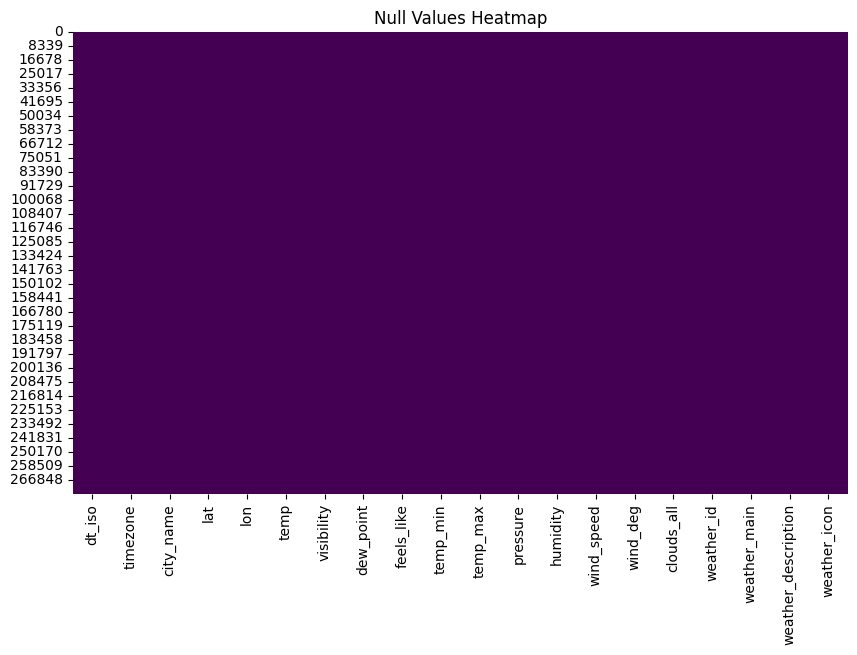

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(weather.isnull(), cbar=False, cmap='viridis')
plt.title('Null Values Heatmap')
plt.show()

Data Cleaning: Handling of Noisy Data

In [ ]:
weather.describe()

timezone            lat           lon           temp  \
count  275168.000000  275168.000000  2.751680e+05  275168.000000   
mean   -15806.766775      40.536772 -8.001996e+01     283.963250   
std      1756.524649       0.000000  5.684352e-14      21.841422   
min    -18000.000000      40.536772 -8.001996e+01   -9725.890000   
25%    -18000.000000      40.536772 -8.001996e+01     275.670000   
50%    -14400.000000      40.536772 -8.001996e+01     284.695000   
75%    -14400.000000      40.536772 -8.001996e+01     292.450000   
max    -14400.000000      40.536772 -8.001996e+01     309.910000   

          visibility      dew_point     feels_like       temp_min  \
count  275168.000000  275168.000000  275168.000000  275168.000000   
mean     9061.165963     278.738308     282.451308     283.219646   
std      2093.190631      10.201194      22.714034      21.858512   
min       100.000000      11.810000   -9732.890000   -9726.040000   
25%      9061.165963     271.070000     272.880000     274.960000   
50%     10000.000000     279.250000     283.830000     283.900000   
75%     10000.000000     287.170000     292.410000     291.740000   
max     10000.000000     302.600000     316.170000     309.360000   

            temp_max       pressure       humidity     wind_speed  \
count  275168.000000  275168.000000  275168.000000  275168.000000   
mean      284.884600    1016.517695      72.203527       3.165662   
std        10.356082       7.216410      18.969923       2.246658   
min        -2.270000     969.000000       0.000000       0.000000   
25%       276.450000    1012.000000      59.000000       1.500000   
50%       285.490000    1017.000000      75.000000       3.100000   
75%       293.260000    1021.000000      88.000000       4.600000   
max       310.500000    1048.000000     100.000000      20.100000   

            wind_deg     clouds_all     weather_id  
count  275168.000000  275168.000000  275168.000000  
mean      177.430021      67.642851     725.966184  
std       113.299781      36.537921     125.733979  
min         0.000000       0.000000     200.000000  
25%        80.000000      40.000000     701.000000  
50%       200.000000      75.000000     801.000000  
75%       270.000000     100.000000     803.000000  
max       360.000000     100.000000     804.000000

<ipython-input-48-6ff5d5162e2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = weather.corr()


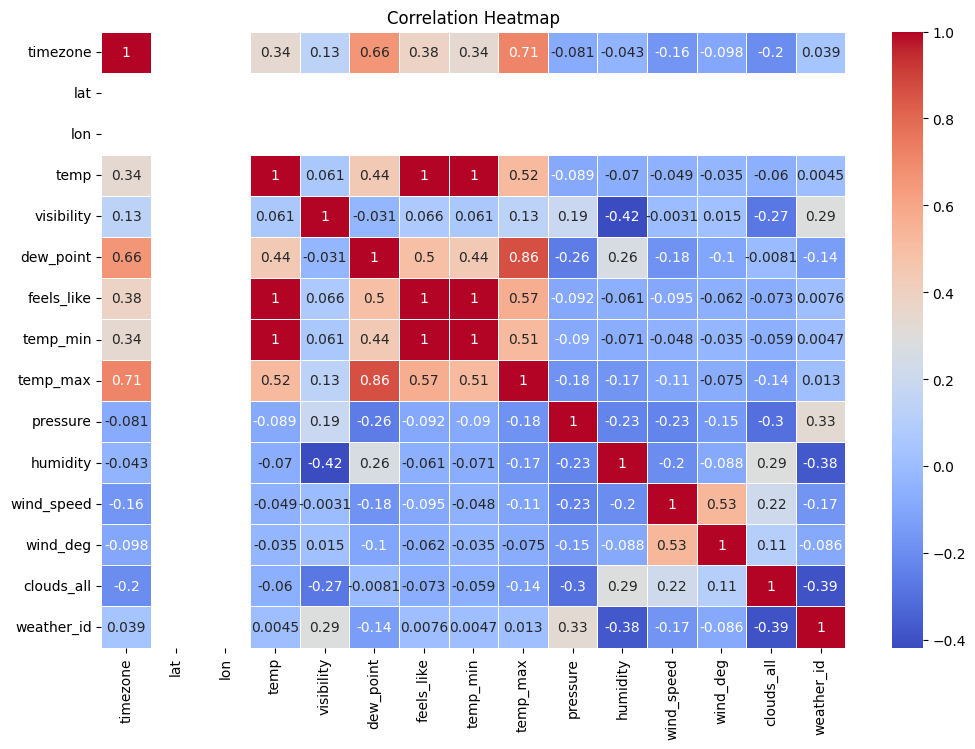

In [ ]:
correlation_matrix = weather.corr()
plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

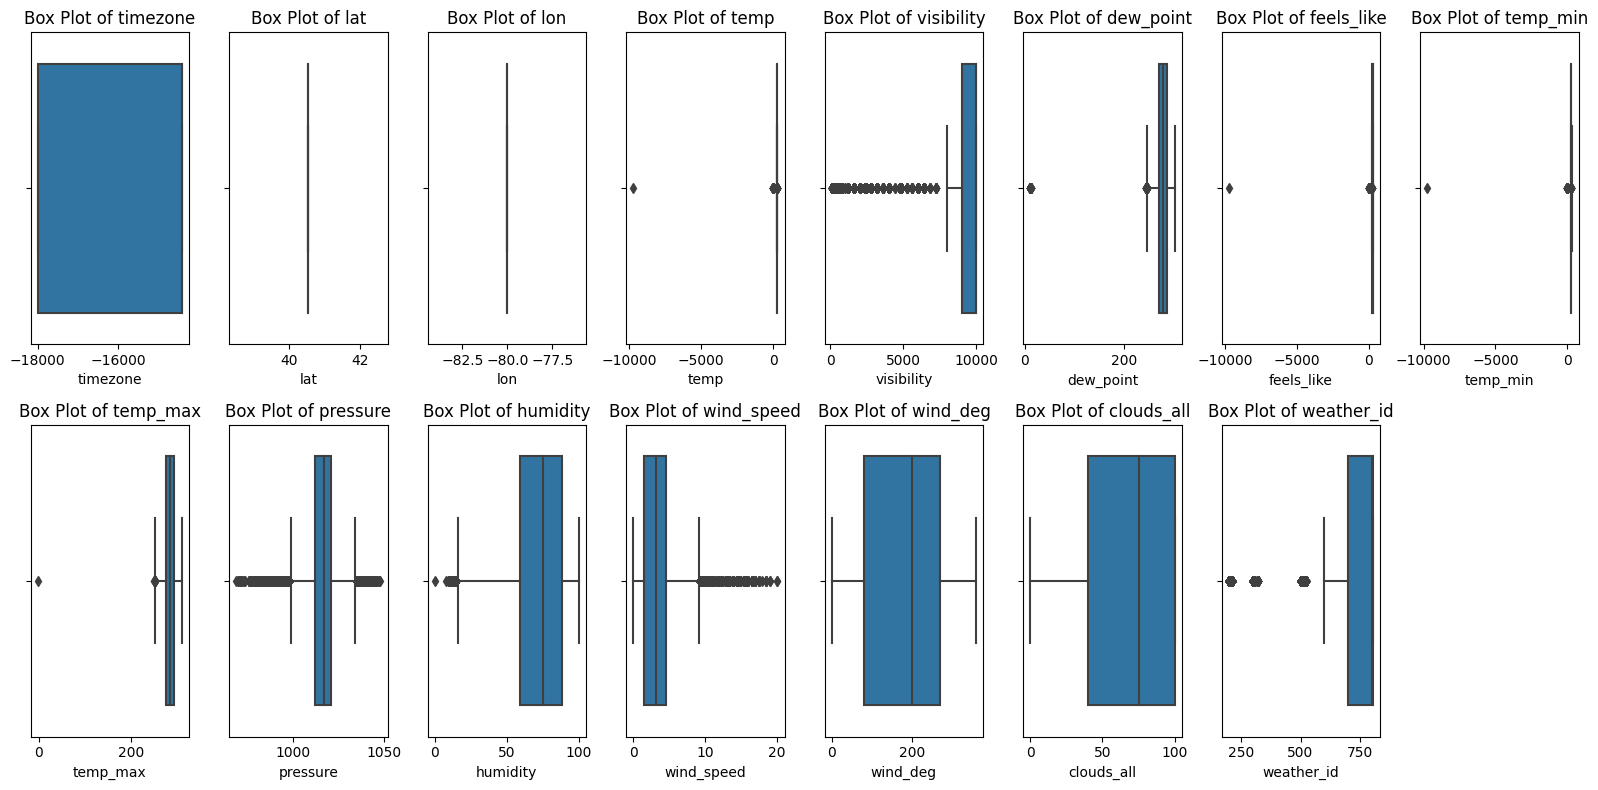

In [ ]:
# Separate numeric and categorical columns
numeric_columns = weather.select_dtypes(include=['number']).columns
categorical_columns = weather.select_dtypes(include=['object']).columns

# Create box plots for numeric columns
plt.figure(figsize=(16, 8))
for i, column in enumerate(numeric_columns):
    plt.subplot(2, (len(numeric_columns)//2)+1, i+1)
    sns.boxplot(x=weather[column])
    plt.title(f'Box Plot of {column}')

plt.tight_layout()
plt.show()

In [ ]:
#In columns temp,feels_like, temp_min, and temp_max which is Kelvin scale, there are values below 0 which is not possible
#and hence changing the values to 0 if it is below 0
weather[weather['temp'] < 0] = 0
weather[weather['feels_like'] < 0] = 0
weather[weather['temp_min'] < 0] = 0
weather[weather['temp_max'] < 0] = 0

In [ ]:
weather.describe()

timezone            lat            lon           temp  \
count  275168.000000  275168.000000  275168.000000  275168.000000   
mean   -15804.804338      40.532353     -80.011232     283.997341   
std      1764.111901       0.423241       0.835482      10.672604   
min    -18000.000000       0.000000     -80.019956       0.000000   
25%    -18000.000000      40.536772     -80.019956     275.670000   
50%    -14400.000000      40.536772     -80.019956     284.695000   
75%    -14400.000000      40.536772     -80.019956     292.450000   
max         0.000000      40.536772       0.000000     309.910000   

          visibility      dew_point     feels_like       temp_min  \
count  275168.000000  275168.000000  275168.000000  275168.000000   
mean     9060.337145     278.736042     282.486061     283.255011   
std      2095.044690      10.248443      12.330011      10.676350   
min         0.000000       0.000000       0.000000       0.000000   
25%      9061.165963     271.070000     272.880000     274.960000   
50%     10000.000000     279.250000     283.830000     283.900000   
75%     10000.000000     287.170000     292.410000     291.740000   
max     10000.000000     302.600000     316.170000     309.360000   

            temp_max       pressure       humidity     wind_speed  \
count  275168.000000  275168.000000  275168.000000  275168.000000   
mean      284.856342    1016.406337      72.194605       3.165460   
std        10.759496      12.834197      18.983934       2.246839   
min         0.000000       0.000000       0.000000       0.000000   
25%       276.450000    1012.000000      59.000000       1.500000   
50%       285.490000    1017.000000      75.000000       3.100000   
75%       293.260000    1021.000000      88.000000       4.600000   
max       310.500000    1048.000000     100.000000      20.100000   

            wind_deg     clouds_all     weather_id  
count  275168.000000  275168.000000  275168.000000  
mean      177.409452      67.632930     725.894145  
std       113.310997      36.543175     125.957559  
min         0.000000       0.000000       0.000000  
25%        80.000000      40.000000     701.000000  
50%       200.000000      75.000000     801.000000  
75%       270.000000     100.000000     803.000000  
max       360.000000     100.000000     804.000000

We can now see that all the values are in the expected range

Data Cleaning: Handling of Inconsistent Data

Column dt_iso has the dates and is originally in object data type. We need to change it to datetime datatype by first removing the string 'UTC' and then changing the data type

In [ ]:
#changing datatypes for weather dataset
weather["dt_iso"] = weather["dt_iso"].str.replace("\sUTC", "")
weather["dt_iso"] = pd.to_datetime(weather["dt_iso"])
weather["dt_iso"].dt.tz_localize(None)
weather['city_name'] = weather['city_name'].astype('str')
weather['weather_main'] = weather['weather_main'].astype('str')
weather['weather_description'] = weather['weather_description'].astype('str')
weather['weather_icon'] = weather['weather_icon'].astype('str')

<ipython-input-20-0f704a5716c0>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  weather["dt_iso"] = weather["dt_iso"].str.replace("\sUTC", "")


In [ ]:
#We can see that the datatypes are changed
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275168 entries, 0 to 275167
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   dt_iso               275138 non-null  datetime64[ns, UTC]
 1   timezone             275168 non-null  int64              
 2   city_name            275168 non-null  object             
 3   lat                  275168 non-null  float64            
 4   lon                  275168 non-null  float64            
 5   temp                 275168 non-null  float64            
 6   visibility           275168 non-null  float64            
 7   dew_point            275168 non-null  float64            
 8   feels_like           275168 non-null  float64            
 9   temp_min             275168 non-null  float64            
 10  temp_max             275168 non-null  float64            
 11  pressure             275168 non-null  int64              
 12  hu

In [ ]:
#converting pandas dataframe to spark
sparkWeatherDF=spark.createDataFrame(weather)

/content/spark-3.1.2-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [ ]:
#displaying unique values using spark dataframe
sparkWeatherDF.select('weather_id','weather_main','weather_description','weather_icon').where("weather_id != 0").distinct().show()

+----------+------------+--------------------+------------+
|weather_id|weather_main| weather_description|weather_icon|
+----------+------------+--------------------+------------+
|       804|      Clouds|     overcast clouds|         04n|
|       801|      Clouds|          few clouds|         02n|
|       800|       Clear|        sky is clear|         01n|
|       600|        Snow|          light snow|         13d|
|       721|        Haze|                haze|         50n|
|       520|        Rain|light intensity s...|         09n|
|       601|        Snow|                snow|         13d|
|       701|        Mist|                mist|         50n|
|       620|        Snow|   light shower snow|         13d|
|       520|        Rain|light intensity s...|         09d|
|       301|     Drizzle|             drizzle|         09n|
|       771|      Squall|   proximity squalls|         50n|
|       202|Thunderstorm|thunderstorm with...|         11n|
|       521|        Rain|         shower

From the above table, we can see that all the descriptive values for
weather related details are unique and are consistent. Hence, the dataset is consistent

In [ ]:
weather.describe()

timezone            lat            lon           temp  \
count  275168.000000  275168.000000  275168.000000  275168.000000   
mean   -15804.804338      40.532353     -80.011232     283.997341   
std      1764.111901       0.423241       0.835482      10.672604   
min    -18000.000000       0.000000     -80.019956       0.000000   
25%    -18000.000000      40.536772     -80.019956     275.670000   
50%    -14400.000000      40.536772     -80.019956     284.695000   
75%    -14400.000000      40.536772     -80.019956     292.450000   
max         0.000000      40.536772       0.000000     309.910000   

          visibility      dew_point     feels_like       temp_min  \
count  275168.000000  275168.000000  275168.000000  275168.000000   
mean     9060.337145     278.736042     282.486061     283.255011   
std      2095.044690      10.248443      12.330011      10.676350   
min         0.000000       0.000000       0.000000       0.000000   
25%      9061.165963     271.070000     272.880000     274.960000   
50%     10000.000000     279.250000     283.830000     283.900000   
75%     10000.000000     287.170000     292.410000     291.740000   
max     10000.000000     302.600000     316.170000     309.360000   

            temp_max       pressure       humidity     wind_speed  \
count  275168.000000  275168.000000  275168.000000  275168.000000   
mean      284.856342    1016.406337      72.194605       3.165460   
std        10.759496      12.834197      18.983934       2.246839   
min         0.000000       0.000000       0.000000       0.000000   
25%       276.450000    1012.000000      59.000000       1.500000   
50%       285.490000    1017.000000      75.000000       3.100000   
75%       293.260000    1021.000000      88.000000       4.600000   
max       310.500000    1048.000000     100.000000      20.100000   

            wind_deg     clouds_all     weather_id  
count  275168.000000  275168.000000  275168.000000  
mean      177.409452      67.632930     725.894145  
std       113.310997      36.543175     125.957559  
min         0.000000       0.000000       0.000000  
25%        80.000000      40.000000     701.000000  
50%       200.000000      75.000000     801.000000  
75%       270.000000     100.000000     803.000000  
max       360.000000     100.000000     804.000000

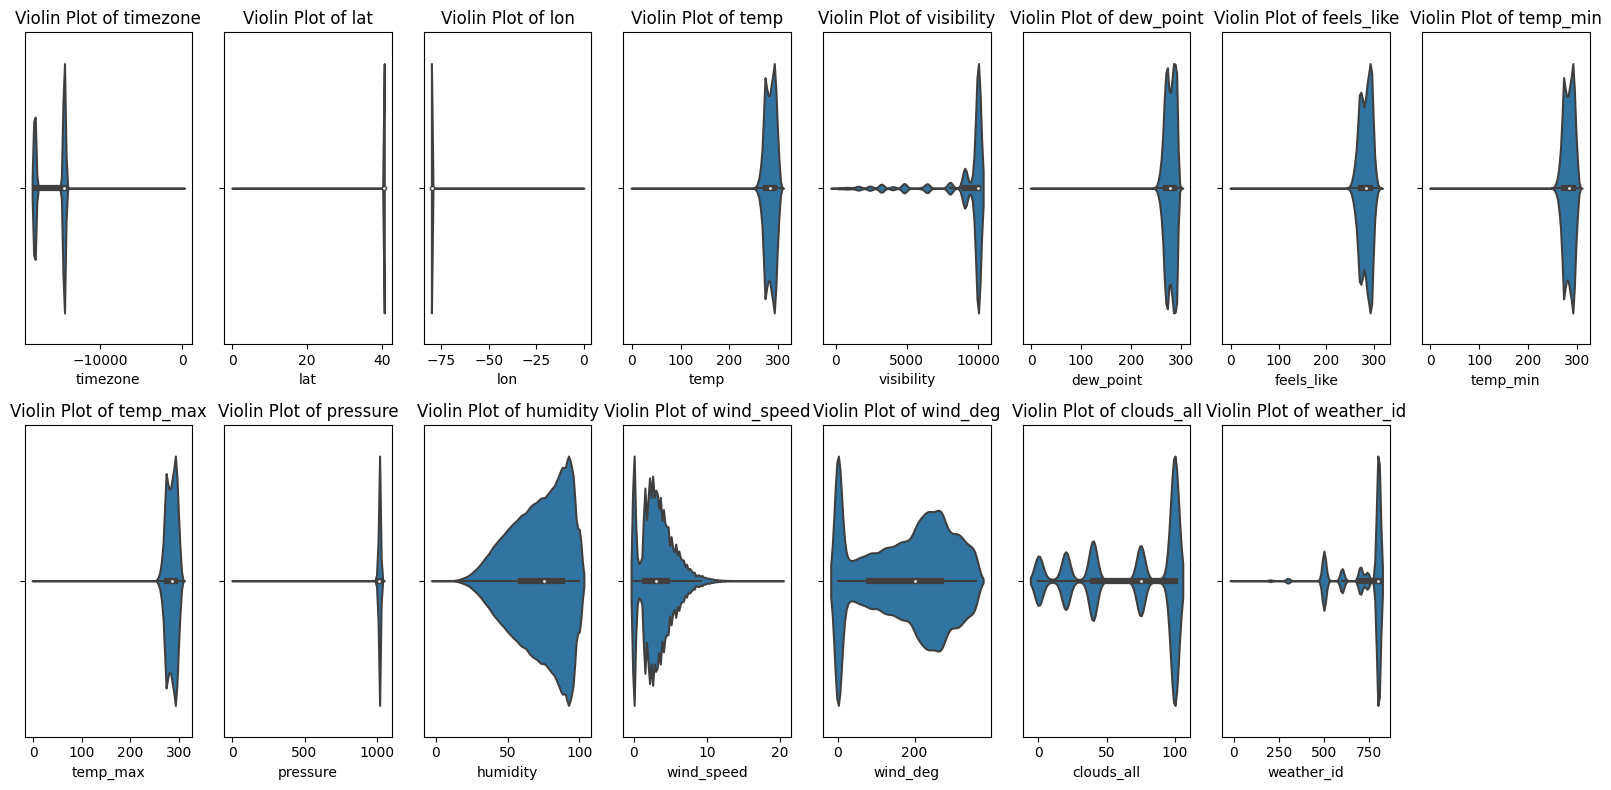

In [ ]:
# Separate numeric and categorical columns
numeric_columns = weather.select_dtypes(include=['number']).columns
categorical_columns = weather.select_dtypes(include=['object']).columns

# Create violin plots for numeric columns
plt.figure(figsize=(16, 8))
for i, column in enumerate(numeric_columns):
    plt.subplot(2, (len(numeric_columns)//2)+1, i+1)
    sns.violinplot(x=weather[column])
    plt.title(f'Violin Plot of {column}')

plt.tight_layout()
plt.show()

Based on dataframe.describe(), all the continuous variables are consistent as well

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag

windowSpec  = Window.orderBy("dt_iso")

sparkWeatherDF.withColumn("lag", datediff(date_add("dt_iso",1),"dt_iso")).where(datediff(date_add("dt_iso",1),"dt_iso")>1).show()
#sparkWeatherDF.where(datediff(lag("dt_iso",1).over(windowSpec),"dt_iso")>1).show()

+------+--------+---------+---+---+----+----------+---------+----------+--------+--------+--------+--------+----------+--------+----------+----------+------------+-------------------+------------+---+
|dt_iso|timezone|city_name|lat|lon|temp|visibility|dew_point|feels_like|temp_min|temp_max|pressure|humidity|wind_speed|wind_deg|clouds_all|weather_id|weather_main|weather_description|weather_icon|lag|
+------+--------+---------+---+---+----+----------+---------+----------+--------+--------+--------+--------+----------+--------+----------+----------+------------+-------------------+------------+---+
+------+--------+---------+---+---+----+----------+---------+----------+--------+--------+--------+--------+----------+--------+----------+----------+------------+-------------------+------------+---+



In [ ]:
sparkWeatherDF.select(month('dt_iso').alias('month'), year('dt_iso').alias('year')).where("dt_iso IS NOT NULL").distinct().sort( year('dt_iso').alias('year'),month('dt_iso').alias('month')).show()

+-----+----+
|month|year|
+-----+----+
|    1|1995|
|    2|1995|
|    3|1995|
|    4|1995|
|    5|1995|
|    6|1995|
|    7|1995|
|    8|1995|
|    9|1995|
|   10|1995|
|   11|1995|
|   12|1995|
|    1|1996|
|    2|1996|
|    3|1996|
|    4|1996|
|    5|1996|
|    6|1996|
|    7|1996|
|    8|1996|
+-----+----+
only showing top 20 rows



**Data Transformation**

In [ ]:
# Join location and crop yield dataset based on the coordinates
int_df = pd.merge(cropYield, location, how ='inner', on =['longitude','latitude'])

In [ ]:
#dropping columns longitude, and latitude since we join to the weather dataset based on the city name
int_df = int_df.drop(columns = ['longitude','latitude'])
#dropping duration_, distance_in, swth_wdth_in, and status  columns since it is not relevant to crop yield prediction
int_df = int_df.drop(columns = ['duration_','distance_in','swth_wdth_in','status'])
#dropping serial_number, pass_num and dataset since they are related to the column called field which is sufficient for crop yield prediction
int_df = int_df.drop(columns = ['serial_number','dataset','pass_num'])
#dropping country, state since the dataset we collected is only from a single city
int_df = int_df.drop(columns = ['country','state'])

In [ ]:
#creating spark dataframe from pandas dataframe
sparkIntDF=spark.createDataFrame(int_df)

/content/spark-3.1.2-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [ ]:
#Selecting the required columns
sparkIntDF = (sparkIntDF.withColumn("datetime", to_timestamp(substring("datetime", 0, 13), "yyyy-MM-dd HH"))
          .withColumn("field", sparkIntDF['field'])
          .withColumn("crop_flow_lb_s", sparkIntDF['crop_flow_lb_s'])
          .withColumn("elevation_ft", sparkIntDF['elevation_ft'])
          .withColumn("moisture", sparkIntDF['moisture'])
          .withColumn("name", sparkIntDF['name'])
          .withColumn("product", sparkIntDF['product']))

In [ ]:
#Aggregating the crop yield data to the hour level to merge with the weather dataset
sparkIntDF.groupBy("datetime","field","product",'name') \
    .agg(avg("crop_flow_lb_s").alias("crop_flow_lb_s"), \
         avg("moisture").alias("moisture"), \
         avg("elevation_ft").alias("elevation_ft") )

DataFrame[datetime: timestamp, field: string, product: string, name: string, crop_flow_lb_s: double, moisture: double, elevation_ft: double]

In [ ]:
#Dropping unnecessary columns from the weather dataset
sparkWeatherDF = sparkWeatherDF.drop('timezone')
sparkWeatherDF = sparkWeatherDF.drop('lat')
sparkWeatherDF = sparkWeatherDF.drop('lon')
sparkWeatherDF = sparkWeatherDF.drop('weather_id')
sparkWeatherDF = sparkWeatherDF.drop('weather_main')
sparkWeatherDF = sparkWeatherDF.drop('weather_description')
sparkWeatherDF = sparkWeatherDF.drop('weather_icon')


In [ ]:
#Making sure that the dataset no duplicates
sparkWeatherDF = sparkWeatherDF.distinct()

In [ ]:
#left join sparkIntDF with the sparkWeatherDF dataframe
final_df = sparkIntDF.join(sparkWeatherDF,[sparkIntDF.datetime == sparkWeatherDF.dt_iso,sparkIntDF.name == sparkWeatherDF.city_name],"left")

In [ ]:
pandasFinalDF = final_df.toPandas()

/content/spark-3.1.2-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:178: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/content/spark-3.1.2-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:178: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


<ipython-input-69-f21e8b8ac9ff>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = pandasFinalDF.corr()


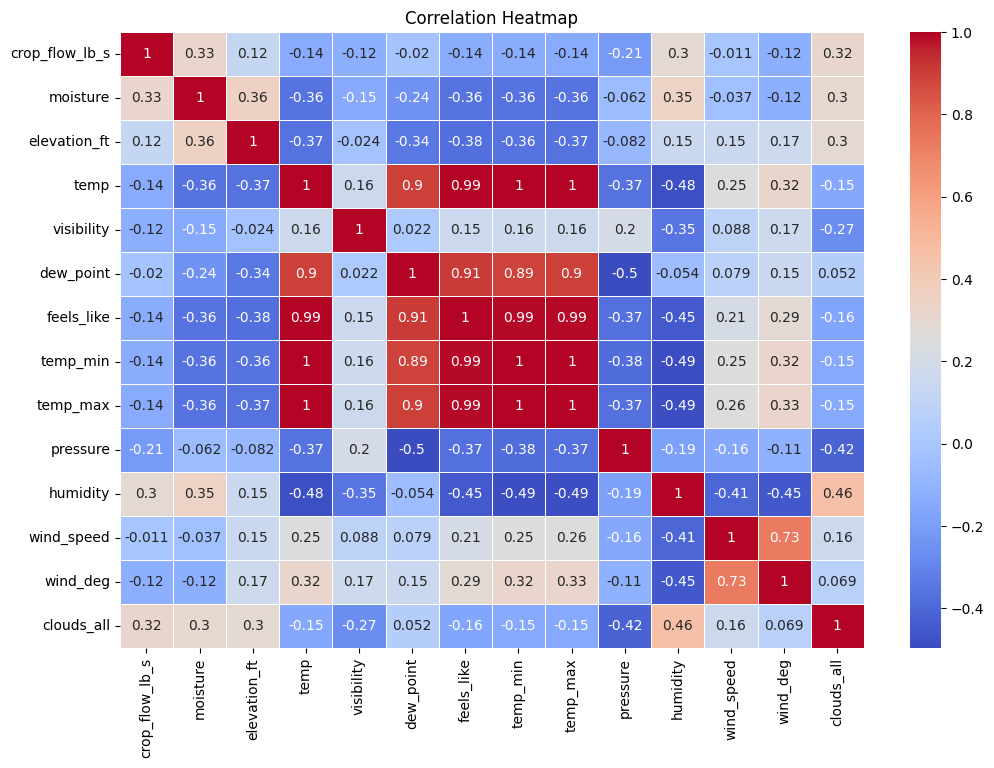

In [ ]:
correlation_matrix = pandasFinalDF.corr()
plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

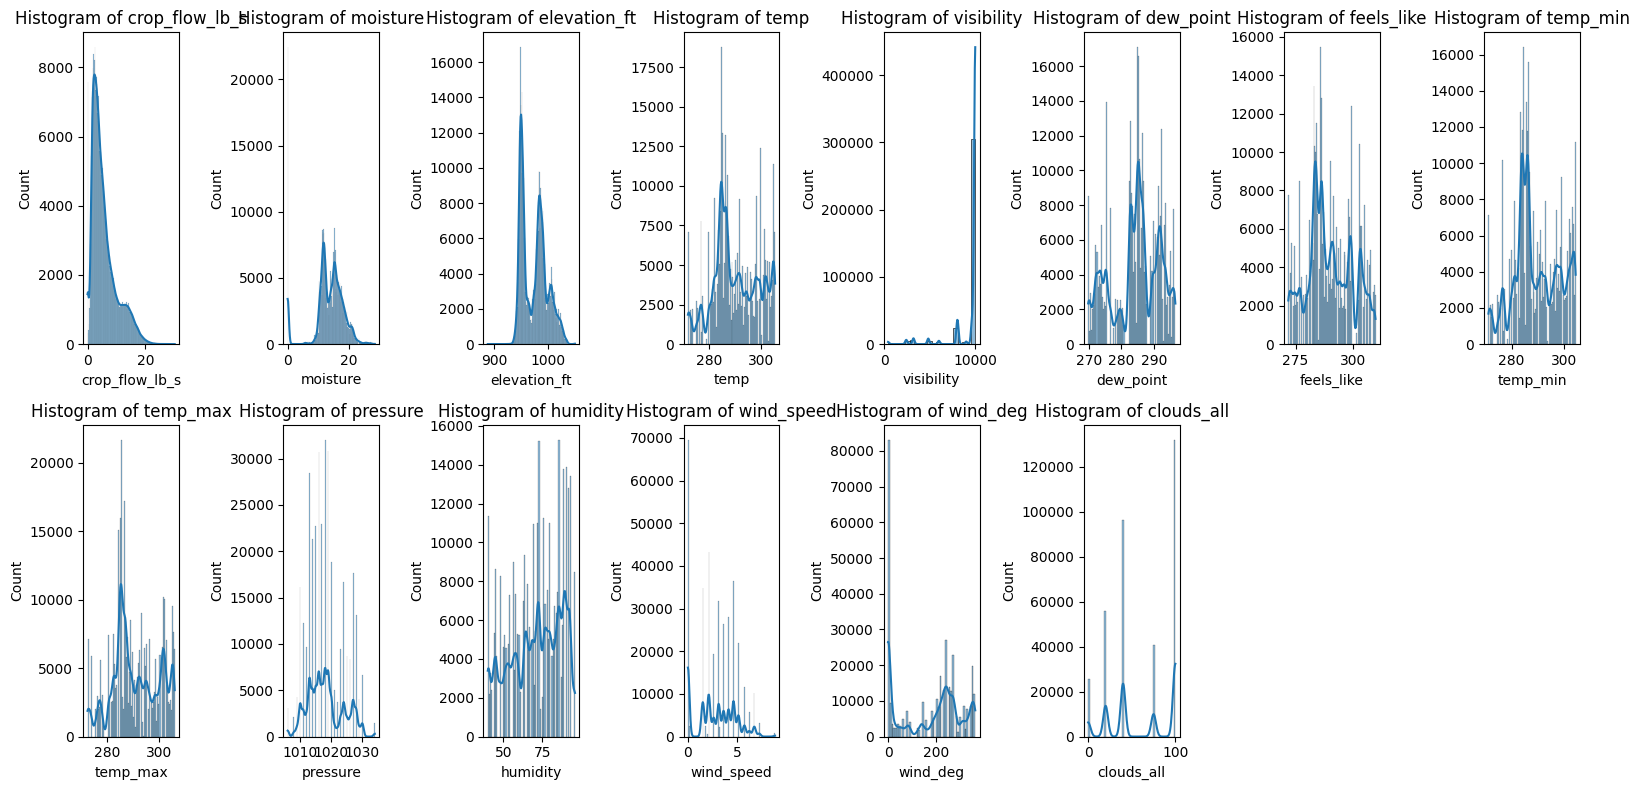

In [ ]:
numeric_columns = pandasFinalDF.select_dtypes(include=['number']).columns

# Multiple Histograms
plt.figure(figsize=(16, 8))
for i, column in enumerate(numeric_columns):
    plt.subplot(2, (len(numeric_columns)//2)+1, i+1)
    sns.histplot(pandasFinalDF[column], kde=True)
    plt.title(f'Histogram of {column}')

plt.tight_layout()
plt.show()


In [ ]:
from google.colab import files

pandasFinalDF.to_csv('transformed_data.csv')
#Uncomment this line only if you want to download the merged data file
#files.download('transformed_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Loading transformed data**

In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Load transformed dataset - Pulling from the shared drive
transformed = pd.read_csv('/content/drive/Shareddrives/GWAR_datasets/transformed_data.csv')
del transformed[transformed.columns[0]]
transformed

crop_flow_lb_s             datetime  moisture          field  \
0                 0.00  2009-10-16 14:00:00     16.70  F1: T2R2-West   
1                 4.80  2009-10-16 14:00:00     15.36  F1: T2R2-West   
2                 4.68  2009-10-16 14:00:00     15.65  F1: T2R5-West   
3                 3.98  2009-10-16 14:00:00     15.65  F1: T2R5-West   
4                 2.98  2009-10-16 14:00:00     15.55  F1: T2R5-West   
...                ...                  ...       ...            ...   
350440           10.60  2007-07-09 18:00:00     11.57  F1: T2R2-East   
350441            9.90  2007-07-09 18:00:00     11.57  F1: T2R2-East   
350442           10.40  2007-07-09 18:00:00     11.57  F1: T2R2-East   
350443            9.70  2007-07-09 18:00:00     11.57  F1: T2R2-East   
350444            9.80  2007-07-09 18:00:00     11.57  F1: T2R2-East   

         product  elevation_ft           name               dt_iso  \
0       Soybeans        997.42  Ross Township  2009-10-16 14:00:00   
1       Soybeans        995.00  Ross Township  2009-10-16 14:00:00   
2       Soybeans       1015.92  Ross Township  2009-10-16 14:00:00   
3       Soybeans       1016.25  Ross Township  2009-10-16 14:00:00   
4       Soybeans       1019.58  Ross Township  2009-10-16 14:00:00   
...          ...           ...            ...                  ...   
350440     Wheat        955.25  Ross Township  2007-07-09 18:00:00   
350441     Wheat        955.25  Ross Township  2007-07-09 18:00:00   
350442     Wheat        955.25  Ross Township  2007-07-09 18:00:00   
350443     Wheat        955.25  Ross Township  2007-07-09 18:00:00   
350444     Wheat        955.58  Ross Township  2007-07-09 18:00:00   

            city_name    temp  visibility  dew_point  feels_like  temp_min  \
0       Ross Township  276.26      8047.0     274.47      274.21    275.95   
1       Ross Township  276.26      8047.0     274.47      274.21    275.95   
2       Ross Township  276.26      8047.0     274.47      274.21    275.95   
3       Ross Township  276.26      8047.0     274.47      274.21    275.95   
4       Ross Township  276.26      8047.0     274.47      274.21    275.95   
...               ...     ...         ...        ...         ...       ...   
350440  Ross Township  305.51     10000.0     292.41      307.21    303.86   
350441  Ross Township  305.51     10000.0     292.41      307.21    303.86   
350442  Ross Township  305.51     10000.0     292.41      307.21    303.86   
350443  Ross Township  305.51     10000.0     292.41      307.21    303.86   
350444  Ross Township  305.51     10000.0     292.41      307.21    303.86   

        temp_max  pressure  humidity  wind_speed  wind_deg  clouds_all  
0         276.45      1012        88        2.10        80         100  
1         276.45      1012        88        2.10        80         100  
2         276.45      1012        88        2.10        80         100  
3         276.45      1012        88        2.10        80         100  
4         276.45      1012        88        2.10        80         100  
...          ...       ...       ...         ...       ...         ...  
350440    305.67      1014        46        3.18       237          40  
350441    305.67      1014        46        3.18       237          40  
350442    305.67      1014        46        3.18       237          40  
350443    305.67      1014        46        3.18       237          40  
350444    305.67      1014        46        3.18       237          40  

[350445 rows x 20 columns]

In [ ]:
transformed.describe()

crop_flow_lb_s       moisture   elevation_ft           temp  \
count   350445.000000  350445.000000  350445.000000  350445.000000   
mean         5.743898      13.810470     975.050931     290.132813   
std          4.287287       4.787515      23.547199       8.724105   
min          0.000000       0.000000     887.920000     271.820000   
25%          2.610000      11.680000     952.170000     284.540000   
50%          4.420000      14.310000     977.750000     288.630000   
75%          7.630000      16.730000     990.830000     297.800000   
max         30.150000      28.530000    1050.670000     305.510000   

          visibility      dew_point     feels_like       temp_min  \
count  350445.000000  350445.000000  350445.000000  350445.000000   
mean     9475.227830     284.339784     289.929605     289.380278   
std      1572.125957       7.314189       9.792275       8.678227   
min       402.000000     269.740000     271.820000     271.060000   
25%     10000.000000     279.150000     283.280000     283.780000   
50%     10000.000000     285.130000     288.110000     286.970000   
75%     10000.000000     290.450000     298.290000     297.210000   
max     10000.000000     296.640000     310.020000     304.650000   

            temp_max       pressure       humidity     wind_speed  \
count  350445.000000  350445.000000  350445.000000  350445.000000   
mean      290.728708    1018.174803      70.870947       2.834836   
std         8.809881       5.590492      16.047961       1.970058   
min       272.300000    1006.000000      40.000000       0.000000   
25%       284.960000    1014.000000      58.000000       1.500000   
50%       288.860000    1018.000000      73.000000       3.100000   
75%       298.810000    1022.000000      85.000000       4.600000   
max       306.060000    1034.000000      96.000000       8.800000   

            wind_deg     clouds_all  
count  350445.000000  350445.000000  
mean      171.718932      60.579777  
std       127.027276      35.444186  
min         0.000000       0.000000  
25%        10.000000      40.000000  
50%       220.000000      40.000000  
75%       270.000000     100.000000  
max       360.000000     100.000000

Data normalization possibilites: elevation_ft, temp, visibility, dew_point, feels_like, temp_min, temp_max, pressure, humidity

**Data Standardization**

In [ ]:
#Standardizing the numerical features to ensure they have the same base scale. This is particularly important for algorithms sensitive to feature scaling.

In [ ]:
numeric_columns=transformed.select_dtypes(include=['int','float']).columns
numeric_columns = numeric_columns.tolist()  # Convert Index to a list
numeric_columns.remove('crop_flow_lb_s')    # Remove the item from the list
numeric_columns = pd.Index(numeric_columns) # Convert the list back to an Index if necessary
numeric_columns

Index(['moisture', 'elevation_ft', 'temp', 'visibility', 'dew_point',
       'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'clouds_all'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import StandardScaler

# Instantiate a StandardScaler
scaler = StandardScaler()
transformed[numeric_columns] = scaler.fit_transform(transformed[numeric_columns])
transformed[numeric_columns]

moisture  elevation_ft      temp  visibility  dew_point  feels_like  \
0       0.603556      0.949969 -1.590173   -0.908470  -1.349404   -1.605309   
1       0.323661      0.847196 -1.590173   -0.908470  -1.349404   -1.605309   
2       0.384235      1.735626 -1.590173   -0.908470  -1.349404   -1.605309   
3       0.384235      1.749640 -1.590173   -0.908470  -1.349404   -1.605309   
4       0.363348      1.891059 -1.590173   -0.908470  -1.349404   -1.605309   
...          ...           ...       ...         ...        ...         ...   
350440 -0.467983     -0.840905  1.762612    0.333798   1.103366    1.764699   
350441 -0.467983     -0.840905  1.762612    0.333798   1.103366    1.764699   
350442 -0.467983     -0.840905  1.762612    0.333798   1.103366    1.764699   
350443 -0.467983     -0.840905  1.762612    0.333798   1.103366    1.764699   
350444 -0.467983     -0.826891  1.762612    0.333798   1.103366    1.764699   

        temp_min  temp_max  pressure  humidity  wind_speed  wind_deg  \
0      -1.547585 -1.620763  -1.10452  1.067368   -0.373003 -0.722042   
1      -1.547585 -1.620763  -1.10452  1.067368   -0.373003 -0.722042   
2      -1.547585 -1.620763  -1.10452  1.067368   -0.373003 -0.722042   
3      -1.547585 -1.620763  -1.10452  1.067368   -0.373003 -0.722042   
4      -1.547585 -1.620763  -1.10452  1.067368   -0.373003 -0.722042   
...          ...       ...       ...       ...         ...       ...   
350440  1.668514  1.695972  -0.74677 -1.549791    0.175205  0.513915   
350441  1.668514  1.695972  -0.74677 -1.549791    0.175205  0.513915   
350442  1.668514  1.695972  -0.74677 -1.549791    0.175205  0.513915   
350443  1.668514  1.695972  -0.74677 -1.549791    0.175205  0.513915   
350444  1.668514  1.695972  -0.74677 -1.549791    0.175205  0.513915   

        clouds_all  
0         1.112179  
1         1.112179  
2         1.112179  
3         1.112179  
4         1.112179  
...            ...  
350440   -0.580626  
350441   -0.580626  
350442   -0.580626  
350443   -0.580626  
350444   -0.580626  

[350445 rows x 13 columns]

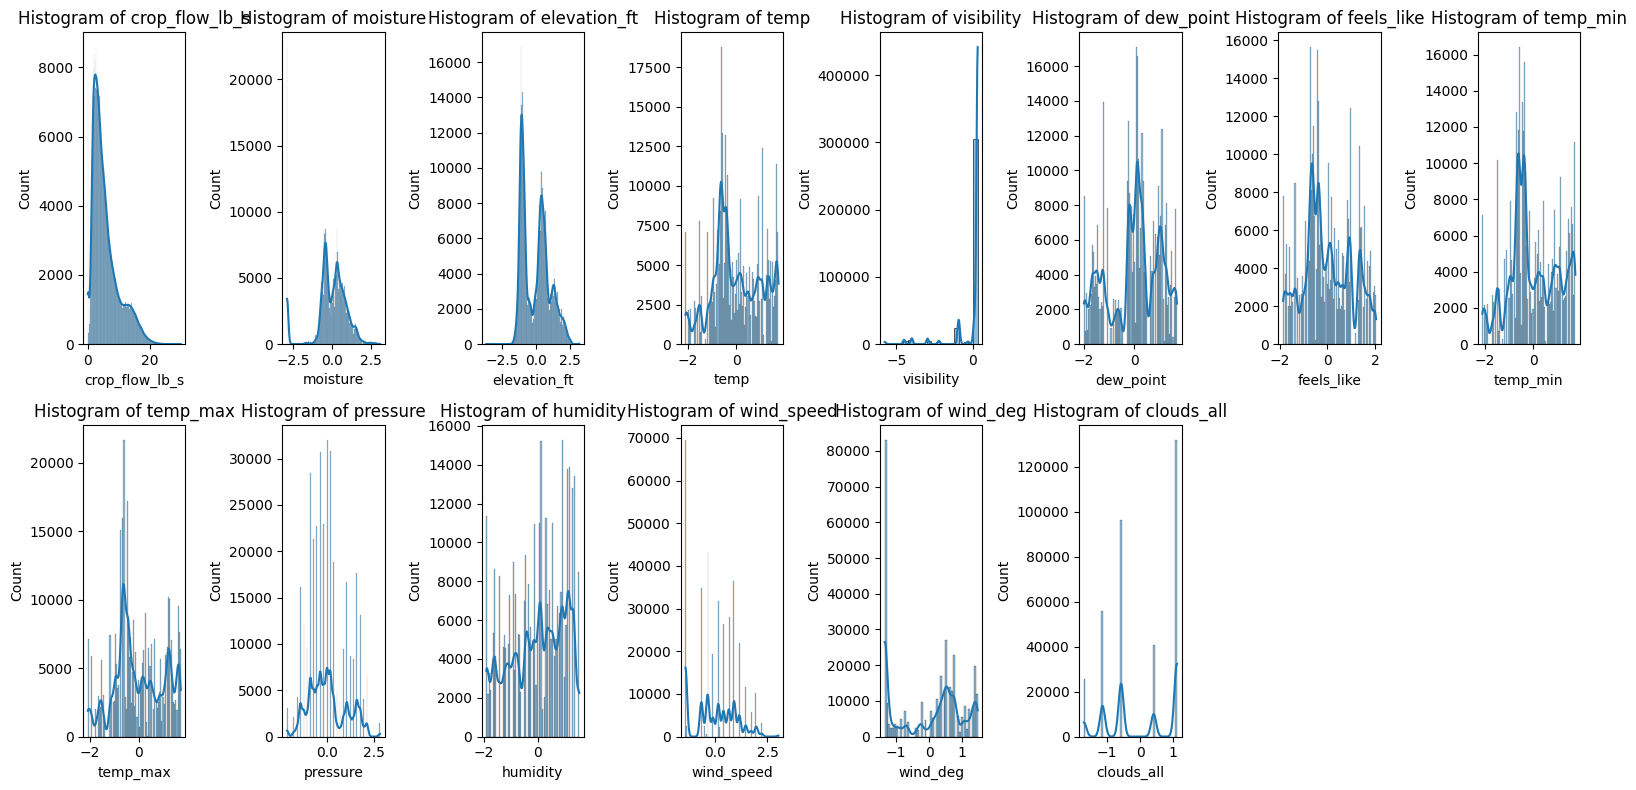

In [ ]:
numeric_columns = transformed.select_dtypes(include=['number']).columns

# Multiple Histograms
plt.figure(figsize=(16, 8))
for i, column in enumerate(numeric_columns):
    plt.subplot(2, (len(numeric_columns)//2)+1, i+1)
    sns.histplot(transformed[column], kde=True)
    plt.title(f'Histogram of {column}')

plt.tight_layout()
plt.show()

In [ ]:
category_columns=transformed.select_dtypes(include=['object']).columns
category_columns

Index(['datetime', 'field', 'product', 'name', 'dt_iso', 'city_name'], dtype='object')

**One Hot Encoding is part of Labeling, can be added as part of Data Transformation,  apart from Data Reduction and Data Regularization**

In [ ]:
# Encoding categorical variables into numerical representations by using one-hot encoding for nominal variables.

In [ ]:
one_hot_encoded = pd.get_dummies(transformed['product'], prefix='product')
# Concatenate the one-hot encoded columns to the original DataFrame
transformed = pd.concat([transformed, one_hot_encoded], axis=1)


In [ ]:
transformed

crop_flow_lb_s             datetime  moisture          field  \
0                 0.00  2009-10-16 14:00:00  0.603556  F1: T2R2-West   
1                 4.80  2009-10-16 14:00:00  0.323661  F1: T2R2-West   
2                 4.68  2009-10-16 14:00:00  0.384235  F1: T2R5-West   
3                 3.98  2009-10-16 14:00:00  0.384235  F1: T2R5-West   
4                 2.98  2009-10-16 14:00:00  0.363348  F1: T2R5-West   
...                ...                  ...       ...            ...   
350440           10.60  2007-07-09 18:00:00 -0.467983  F1: T2R2-East   
350441            9.90  2007-07-09 18:00:00 -0.467983  F1: T2R2-East   
350442           10.40  2007-07-09 18:00:00 -0.467983  F1: T2R2-East   
350443            9.70  2007-07-09 18:00:00 -0.467983  F1: T2R2-East   
350444            9.80  2007-07-09 18:00:00 -0.467983  F1: T2R2-East   

         product  elevation_ft           name               dt_iso  \
0       Soybeans      0.949969  Ross Township  2009-10-16 14:00:00   
1       Soybeans      0.847196  Ross Township  2009-10-16 14:00:00   
2       Soybeans      1.735626  Ross Township  2009-10-16 14:00:00   
3       Soybeans      1.749640  Ross Township  2009-10-16 14:00:00   
4       Soybeans      1.891059  Ross Township  2009-10-16 14:00:00   
...          ...           ...            ...                  ...   
350440     Wheat     -0.840905  Ross Township  2007-07-09 18:00:00   
350441     Wheat     -0.840905  Ross Township  2007-07-09 18:00:00   
350442     Wheat     -0.840905  Ross Township  2007-07-09 18:00:00   
350443     Wheat     -0.840905  Ross Township  2007-07-09 18:00:00   
350444     Wheat     -0.826891  Ross Township  2007-07-09 18:00:00   

            city_name      temp  ...  temp_min  temp_max  pressure  humidity  \
0       Ross Township -1.590173  ... -1.547585 -1.620763  -1.10452  1.067368   
1       Ross Township -1.590173  ... -1.547585 -1.620763  -1.10452  1.067368   
2       Ross Township -1.590173  ... -1.547585 -1.620763  -1.10452  1.067368   
3       Ross Township -1.590173  ... -1.547585 -1.620763  -1.10452  1.067368   
4       Ross Township -1.590173  ... -1.547585 -1.620763  -1.10452  1.067368   
...               ...       ...  ...       ...       ...       ...       ...   
350440  Ross Township  1.762612  ...  1.668514  1.695972  -0.74677 -1.549791   
350441  Ross Township  1.762612  ...  1.668514  1.695972  -0.74677 -1.549791   
350442  Ross Township  1.762612  ...  1.668514  1.695972  -0.74677 -1.549791   
350443  Ross Township  1.762612  ...  1.668514  1.695972  -0.74677 -1.549791   
350444  Ross Township  1.762612  ...  1.668514  1.695972  -0.74677 -1.549791   

        wind_speed  wind_deg  clouds_all  product_Corn  product_Soybeans  \
0        -0.373003 -0.722042    1.112179             0                 1   
1        -0.373003 -0.722042    1.112179             0                 1   
2        -0.373003 -0.722042    1.112179             0                 1   
3        -0.373003 -0.722042    1.112179             0                 1   
4        -0.373003 -0.722042    1.112179             0                 1   
...            ...       ...         ...           ...               ...   
350440    0.175205  0.513915   -0.580626             0                 0   
350441    0.175205  0.513915   -0.580626             0                 0   
350442    0.175205  0.513915   -0.580626             0                 0   
350443    0.175205  0.513915   -0.580626             0                 0   
350444    0.175205  0.513915   -0.580626             0                 0   

        product_Wheat  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
...               ...  
350440              1  
350441              1  
350442              1  
350443              1  
350444              1  

[350445 rows x 23 columns]

In [ ]:
transformed.drop(columns=['dt_iso','name','product'],inplace=True)


In [ ]:
transformed

crop_flow_lb_s             datetime  moisture          field  \
0                 0.00  2009-10-16 14:00:00  0.603556  F1: T2R2-West   
1                 4.80  2009-10-16 14:00:00  0.323661  F1: T2R2-West   
2                 4.68  2009-10-16 14:00:00  0.384235  F1: T2R5-West   
3                 3.98  2009-10-16 14:00:00  0.384235  F1: T2R5-West   
4                 2.98  2009-10-16 14:00:00  0.363348  F1: T2R5-West   
...                ...                  ...       ...            ...   
350440           10.60  2007-07-09 18:00:00 -0.467983  F1: T2R2-East   
350441            9.90  2007-07-09 18:00:00 -0.467983  F1: T2R2-East   
350442           10.40  2007-07-09 18:00:00 -0.467983  F1: T2R2-East   
350443            9.70  2007-07-09 18:00:00 -0.467983  F1: T2R2-East   
350444            9.80  2007-07-09 18:00:00 -0.467983  F1: T2R2-East   

        elevation_ft      city_name      temp  visibility  dew_point  \
0           0.949969  Ross Township -1.590173   -0.908470  -1.349404   
1           0.847196  Ross Township -1.590173   -0.908470  -1.349404   
2           1.735626  Ross Township -1.590173   -0.908470  -1.349404   
3           1.749640  Ross Township -1.590173   -0.908470  -1.349404   
4           1.891059  Ross Township -1.590173   -0.908470  -1.349404   
...              ...            ...       ...         ...        ...   
350440     -0.840905  Ross Township  1.762612    0.333798   1.103366   
350441     -0.840905  Ross Township  1.762612    0.333798   1.103366   
350442     -0.840905  Ross Township  1.762612    0.333798   1.103366   
350443     -0.840905  Ross Township  1.762612    0.333798   1.103366   
350444     -0.826891  Ross Township  1.762612    0.333798   1.103366   

        feels_like  temp_min  temp_max  pressure  humidity  wind_speed  \
0        -1.605309 -1.547585 -1.620763  -1.10452  1.067368   -0.373003   
1        -1.605309 -1.547585 -1.620763  -1.10452  1.067368   -0.373003   
2        -1.605309 -1.547585 -1.620763  -1.10452  1.067368   -0.373003   
3        -1.605309 -1.547585 -1.620763  -1.10452  1.067368   -0.373003   
4        -1.605309 -1.547585 -1.620763  -1.10452  1.067368   -0.373003   
...            ...       ...       ...       ...       ...         ...   
350440    1.764699  1.668514  1.695972  -0.74677 -1.549791    0.175205   
350441    1.764699  1.668514  1.695972  -0.74677 -1.549791    0.175205   
350442    1.764699  1.668514  1.695972  -0.74677 -1.549791    0.175205   
350443    1.764699  1.668514  1.695972  -0.74677 -1.549791    0.175205   
350444    1.764699  1.668514  1.695972  -0.74677 -1.549791    0.175205   

        wind_deg  clouds_all  product_Corn  product_Soybeans  product_Wheat  
0      -0.722042    1.112179             0                 1              0  
1      -0.722042    1.112179             0                 1              0  
2      -0.722042    1.112179             0                 1              0  
3      -0.722042    1.112179             0                 1              0  
4      -0.722042    1.112179             0                 1              0  
...          ...         ...           ...               ...            ...  
350440  0.513915   -0.580626             0                 0              1  
350441  0.513915   -0.580626             0                 0              1  
350442  0.513915   -0.580626             0                 0              1  
350443  0.513915   -0.580626             0                 0              1  
350444  0.513915   -0.580626             0                 0              1  

[350445 rows x 20 columns]

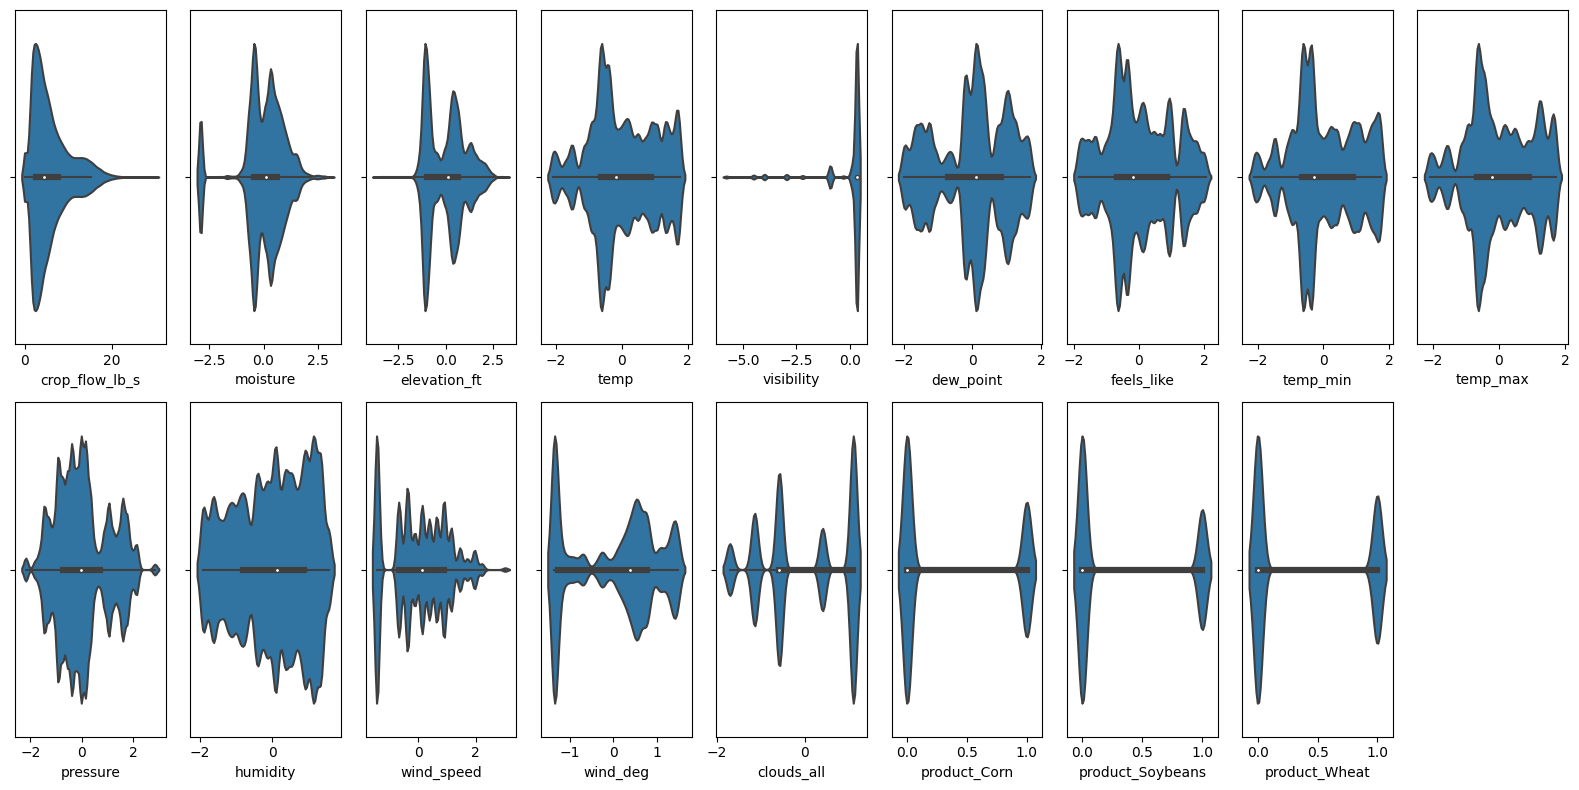

In [ ]:
numeric_columns = transformed.select_dtypes(include=['number']).columns
categorical_columns = transformed.select_dtypes(include=['object']).columns

# Create violin plots for numeric columns
plt.figure(figsize=(16, 8))
for i, column in enumerate(numeric_columns):
    plt.subplot(2, (len(numeric_columns)//2)+1, i+1)
    sns.violinplot(x=transformed[column])

plt.tight_layout()
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

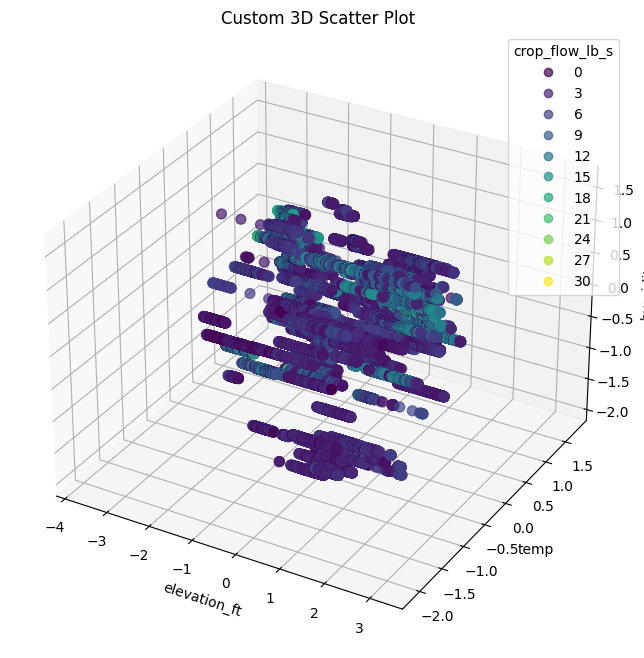

In [ ]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color-coded points based on the number of cylinders
scatter = ax.scatter(transformed['elevation_ft'], transformed['temp'], transformed['humidity'], c=transformed['crop_flow_lb_s'], cmap='viridis', s=50, alpha=0.7)

# Customize the plot appearance
ax.set_xlabel('elevation_ft')
ax.set_ylabel('temp')
ax.set_zlabel('humidity')
ax.set_title('Custom 3D Scatter Plot')
ax.legend(*scatter.legend_elements(), title='crop_flow_lb_s')

# Show the plot
plt.show()

In [ ]:
from google.colab import files

transformed.to_csv('transformed.csv')
files.download('transformed.csv')

KeyboardInterrupt: ignored

**Data Regularization should be L1 L2 Regularization on a dummy regressor**

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error

In [ ]:
numeric_columns=transformed.select_dtypes(include=['int','float']).columns
numeric_columns = numeric_columns.tolist()  # Convert Index to a list
numeric_columns.remove('crop_flow_lb_s')    # Remove the item from the list
numeric_columns = pd.Index(numeric_columns) # Convert the list back to an Index if necessary
numeric_columns

Index(['moisture', 'elevation_ft', 'temp', 'visibility', 'dew_point',
       'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'clouds_all'],
      dtype='object')

In [ ]:
X = transformed[numeric_columns]
y = transformed['crop_flow_lb_s']

**Lasso and Ridge Regression before PCA**

This performs:
1. 10-fold cross validation on Lasso and Ridge models
2. Calculates MAE using mean_absolute_error as the scoring metric
3. Prints the mean MAE and standard MAE for each model

In [ ]:
# Define the grid of hyperparameters to search
hyperparameters = {'alpha': [0.1, 1, 10]}

# Lasso regression
lasso = Lasso()
random_lasso = RandomizedSearchCV(lasso, hyperparameters, n_iter=100, scoring='neg_mean_absolute_error', cv=KFold(10), n_jobs=-1)
random_lasso.fit(X, y)
best_lasso = random_lasso.best_estimator_
lasso_scores = cross_val_score(best_lasso, X, y, scoring='neg_mean_absolute_error', cv=KFold(10), n_jobs=-1)

# Apply abs() to each element of the array
abs_lasso_scores = np.abs(lasso_scores)

print('Lasso MAE: ', abs_lasso_scores.mean())
print('Lasso Standard Deviation: ', lasso_scores.std())

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=100. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Lasso MAE:  3.086290941049939
Lasso Standard Deviation:  0.2341328621646652


In [ ]:
# Ridge regression
ridge = Ridge()
random_ridge = RandomizedSearchCV(ridge, hyperparameters, n_iter=100, scoring='neg_mean_absolute_error', cv=KFold(10), n_jobs=-1)
random_ridge.fit(X, y)
best_ridge = random_ridge.best_estimator_
ridge_scores = cross_val_score(best_ridge, X, y, scoring='neg_mean_absolute_error', cv=KFold(10), n_jobs=-1)
# Apply abs() to each element of the array
abs_ridge_scores = np.abs(ridge_scores)
print('Ridge MAE: ', abs_ridge_scores.mean())
print('Ridge Standard Deviation: ', ridge_scores.std())

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=100. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Ridge MAE:  3.101790861164756
Ridge Standard Deviation:  0.2873037026766126


In [ ]:
lasso_mae=abs_lasso_scores.mean()
ridge_mae=abs_ridge_scores.mean()
lasso_std=lasso_scores.std()
ridge_std=ridge_scores.std()

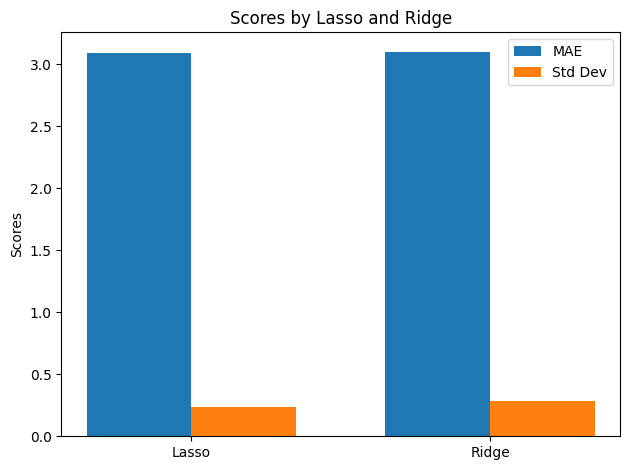

In [ ]:
# Data to plot
labels = ['Lasso', 'Ridge']
mae_values = [lasso_mae, ridge_mae]
std_values = [lasso_std, ridge_std]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, mae_values, width, label='MAE')
rects2 = ax.bar(x + width/2, std_values, width, label='Std Dev')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by Lasso and Ridge')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

**Data Reduction**

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# PRINCIPAL COMPONENT ANALYSIS

In [ ]:
pca = PCA()
transformed[numeric_columns] = pca.fit_transform(transformed[numeric_columns])

In [ ]:
numeric_columns

Index(['moisture', 'elevation_ft', 'temp', 'visibility', 'dew_point',
       'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'clouds_all'],
      dtype='object')

In [ ]:
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:")
print(explained_variance_ratio)

Explained Variance Ratio:
[4.41696072e-01 1.66555598e-01 1.50378739e-01 6.68582225e-02
 5.19266054e-02 4.47876633e-02 3.16587101e-02 2.64453941e-02
 1.84830785e-02 6.31488225e-04 3.52898443e-04 1.50256844e-04
 7.52731753e-05]


In [ ]:
# Choosing the number of components to retain based on the explained variance
cumulative_explained_variance = explained_variance_ratio.cumsum()
num_components = len(cumulative_explained_variance[cumulative_explained_variance < 0.95]) + 1
num_components

7

In [ ]:
# Fit PCA with the chosen number of components
transformed_numeric = transformed[numeric_columns]
pca = PCA(n_components=num_components)
transformed_num = pca.fit_transform(transformed_numeric)

In [ ]:
transformed_num

array([[ 3.78165778,  1.59720559, -0.23156907, ..., -0.42258228,
         0.49963419, -0.86252802],
       [ 3.71315757,  1.50276311, -0.15634619, ..., -0.62366254,
         0.53200402, -0.86815356],
       [ 3.87277396,  1.6730783 , -0.5148771 , ..., -0.54580267,
         1.1582492 , -0.60407779],
       ...,
       [-4.10097433, -0.35848367,  0.17278968, ...,  0.45302601,
         0.1249367 , -0.42742202],
       [-4.10097433, -0.35848367,  0.17278968, ...,  0.45302601,
         0.1249367 , -0.42742202],
       [-4.09863168, -0.35605876,  0.16725225, ...,  0.45358166,
         0.13518233, -0.42316912]])

In [ ]:
# Printing the loadings for each attribute in each principal component
loadings_df = pd.DataFrame(pca.components_, columns=transformed_numeric.columns)
print("Loadings:")
print(loadings_df)

Loadings:
   moisture  elevation_ft          temp    visibility     dew_point  \
0       1.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1      -0.0  1.000000e+00 -1.221245e-15  5.828671e-16  4.996004e-16   
2       0.0  1.110223e-15  1.000000e+00 -1.387779e-16  0.000000e+00   
3       0.0 -1.387779e-16  8.326673e-17  1.000000e+00  5.828671e-16   
4       0.0 -5.551115e-16 -2.220446e-16 -5.898060e-16  1.000000e+00   
5       0.0  1.665335e-16 -2.220446e-16 -1.124101e-15  6.265821e-15   
6       0.0  1.262553e-16  1.369009e-16  1.695201e-16 -3.376883e-16   

     feels_like      temp_min      temp_max      pressure      humidity  \
0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1 -6.938894e-17 -1.343326e-16  3.330669e-16  1.734723e-17  3.122502e-17   
2  1.665335e-16 -1.465841e-16 -4.440892e-16  1.942890e-16  0.000000e+00   
3  1.339207e-15 -3.183760e-16 -5.412337e-16 -1.769418e-16  3.729655e-17   
4 -5.880713e-15  4.505267e-16  1.068590e-15 -6

In [ ]:
#  Here's how you can interpret the loadings:

# Each row corresponds to a principal component (PC).
# Each column corresponds to an original attribute in your dataset.

In [ ]:
pc_columns = [f'PC{i+1}' for i in range(transformed_num.shape[1])]
crop_data_pc = pd.DataFrame(data=transformed_num, columns=pc_columns)
crop_data_pc

PC1       PC2       PC3       PC4       PC5       PC6       PC7
0       3.781658  1.597206 -0.231569  0.327539 -0.422582  0.499634 -0.862528
1       3.713158  1.502763 -0.156346  0.495098 -0.623663  0.532004 -0.868154
2       3.872774  1.673078 -0.514877  0.147105 -0.545803  1.158249 -0.604078
3       3.875117  1.675503 -0.520415  0.142061 -0.545247  1.168495 -0.599825
4       3.894926  1.694252 -0.573709  0.100911 -0.554342  1.279905 -0.555002
...          ...       ...       ...       ...       ...       ...       ...
350440 -4.100974 -0.358484  0.172790 -0.145473  0.453026  0.124937 -0.427422
350441 -4.100974 -0.358484  0.172790 -0.145473  0.453026  0.124937 -0.427422
350442 -4.100974 -0.358484  0.172790 -0.145473  0.453026  0.124937 -0.427422
350443 -4.100974 -0.358484  0.172790 -0.145473  0.453026  0.124937 -0.427422
350444 -4.098632 -0.356059  0.167252 -0.150516  0.453582  0.135182 -0.423169

[350445 rows x 7 columns]

In [ ]:
transformed_pc = pd.concat([transformed, crop_data_pc], axis=1)
transformed_pc

crop_flow_lb_s             datetime  moisture          field  \
0                 0.00  2009-10-16 14:00:00  3.781658  F1: T2R2-West   
1                 4.80  2009-10-16 14:00:00  3.713158  F1: T2R2-West   
2                 4.68  2009-10-16 14:00:00  3.872774  F1: T2R5-West   
3                 3.98  2009-10-16 14:00:00  3.875117  F1: T2R5-West   
4                 2.98  2009-10-16 14:00:00  3.894926  F1: T2R5-West   
...                ...                  ...       ...            ...   
350440           10.60  2007-07-09 18:00:00 -4.100974  F1: T2R2-East   
350441            9.90  2007-07-09 18:00:00 -4.100974  F1: T2R2-East   
350442           10.40  2007-07-09 18:00:00 -4.100974  F1: T2R2-East   
350443            9.70  2007-07-09 18:00:00 -4.100974  F1: T2R2-East   
350444            9.80  2007-07-09 18:00:00 -4.098632  F1: T2R2-East   

        elevation_ft      city_name      temp  visibility  dew_point  \
0           1.597206  Ross Township -0.231569    0.327539  -0.422582   
1           1.502763  Ross Township -0.156346    0.495098  -0.623663   
2           1.673078  Ross Township -0.514877    0.147105  -0.545803   
3           1.675503  Ross Township -0.520415    0.142061  -0.545247   
4           1.694252  Ross Township -0.573709    0.100911  -0.554342   
...              ...            ...       ...         ...        ...   
350440     -0.358484  Ross Township  0.172790   -0.145473   0.453026   
350441     -0.358484  Ross Township  0.172790   -0.145473   0.453026   
350442     -0.358484  Ross Township  0.172790   -0.145473   0.453026   
350443     -0.358484  Ross Township  0.172790   -0.145473   0.453026   
350444     -0.356059  Ross Township  0.167252   -0.150516   0.453582   

        feels_like  ...  product_Corn  product_Soybeans  product_Wheat  \
0         0.499634  ...             0                 1              0   
1         0.532004  ...             0                 1              0   
2         1.158249  ...             0                 1              0   
3         1.168495  ...             0                 1              0   
4         1.279905  ...             0                 1              0   
...            ...  ...           ...               ...            ...   
350440    0.124937  ...             0                 0              1   
350441    0.124937  ...             0                 0              1   
350442    0.124937  ...             0                 0              1   
350443    0.124937  ...             0                 0              1   
350444    0.135182  ...             0                 0              1   

             PC1       PC2       PC3       PC4       PC5       PC6       PC7  
0       3.781658  1.597206 -0.231569  0.327539 -0.422582  0.499634 -0.862528  
1       3.713158  1.502763 -0.156346  0.495098 -0.623663  0.532004 -0.868154  
2       3.872774  1.673078 -0.514877  0.147105 -0.545803  1.158249 -0.604078  
3       3.875117  1.675503 -0.520415  0.142061 -0.545247  1.168495 -0.599825  
4       3.894926  1.694252 -0.573709  0.100911 -0.554342  1.279905 -0.555002  
...          ...       ...       ...       ...       ...       ...       ...  
350440 -4.100974 -0.358484  0.172790 -0.145473  0.453026  0.124937 -0.427422  
350441 -4.100974 -0.358484  0.172790 -0.145473  0.453026  0.124937 -0.427422  
350442 -4.100974 -0.358484  0.172790 -0.145473  0.453026  0.124937 -0.427422  
350443 -4.100974 -0.358484  0.172790 -0.145473  0.453026  0.124937 -0.427422  
350444 -4.098632 -0.356059  0.167252 -0.150516  0.453582  0.135182 -0.423169  

[350445 rows x 27 columns]

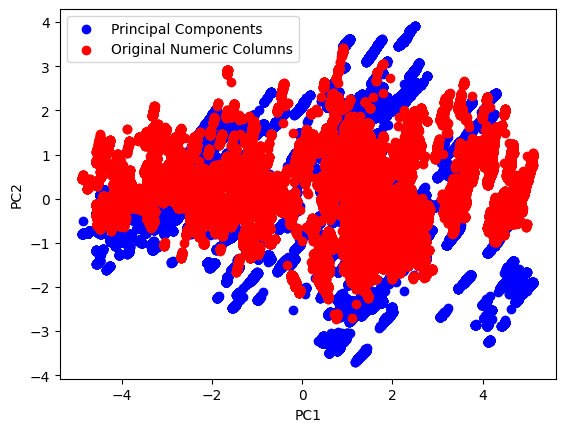

In [ ]:
#  'transformed_pc' contains both original and principal component columns
plt.scatter(transformed_pc['PC1'], transformed_pc['PC2'], c='blue', label='Principal Components')
plt.scatter(transformed_pc['moisture'], transformed_pc['feels_like'], c='red', label='Original Numeric Columns')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()


In [ ]:
# It's more about evaluating whether the reduced-dimensional representation meets our specific needs and does not significantly compromise the information relevant to our
#  analysis or modeling. As long as the principal components represent a similar pattern of original features, it is sufficient to train the model.

# Two components are just compared to two of the original attributes and we get such a pattern. But the component is a combination of different features. On a combined perspective
# we decrease data but retain its information.

In [ ]:
transformed_pc.drop(columns=['moisture', 'elevation_ft', 'temp', 'visibility', 'dew_point',
       'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'clouds_all'],inplace=True)

In [ ]:
transformed_pc

crop_flow_lb_s             datetime          field      city_name  \
0                 0.00  2009-10-16 14:00:00  F1: T2R2-West  Ross Township   
1                 4.80  2009-10-16 14:00:00  F1: T2R2-West  Ross Township   
2                 4.68  2009-10-16 14:00:00  F1: T2R5-West  Ross Township   
3                 3.98  2009-10-16 14:00:00  F1: T2R5-West  Ross Township   
4                 2.98  2009-10-16 14:00:00  F1: T2R5-West  Ross Township   
...                ...                  ...            ...            ...   
350440           10.60  2007-07-09 18:00:00  F1: T2R2-East  Ross Township   
350441            9.90  2007-07-09 18:00:00  F1: T2R2-East  Ross Township   
350442           10.40  2007-07-09 18:00:00  F1: T2R2-East  Ross Township   
350443            9.70  2007-07-09 18:00:00  F1: T2R2-East  Ross Township   
350444            9.80  2007-07-09 18:00:00  F1: T2R2-East  Ross Township   

        product_Corn  product_Soybeans  product_Wheat       PC1       PC2  \
0                  0                 1              0  3.781658  1.597206   
1                  0                 1              0  3.713158  1.502763   
2                  0                 1              0  3.872774  1.673078   
3                  0                 1              0  3.875117  1.675503   
4                  0                 1              0  3.894926  1.694252   
...              ...               ...            ...       ...       ...   
350440             0                 0              1 -4.100974 -0.358484   
350441             0                 0              1 -4.100974 -0.358484   
350442             0                 0              1 -4.100974 -0.358484   
350443             0                 0              1 -4.100974 -0.358484   
350444             0                 0              1 -4.098632 -0.356059   

             PC3       PC4       PC5       PC6       PC7  
0      -0.231569  0.327539 -0.422582  0.499634 -0.862528  
1      -0.156346  0.495098 -0.623663  0.532004 -0.868154  
2      -0.514877  0.147105 -0.545803  1.158249 -0.604078  
3      -0.520415  0.142061 -0.545247  1.168495 -0.599825  
4      -0.573709  0.100911 -0.554342  1.279905 -0.555002  
...          ...       ...       ...       ...       ...  
350440  0.172790 -0.145473  0.453026  0.124937 -0.427422  
350441  0.172790 -0.145473  0.453026  0.124937 -0.427422  
350442  0.172790 -0.145473  0.453026  0.124937 -0.427422  
350443  0.172790 -0.145473  0.453026  0.124937 -0.427422  
350444  0.167252 -0.150516  0.453582  0.135182 -0.423169  

[350445 rows x 14 columns]

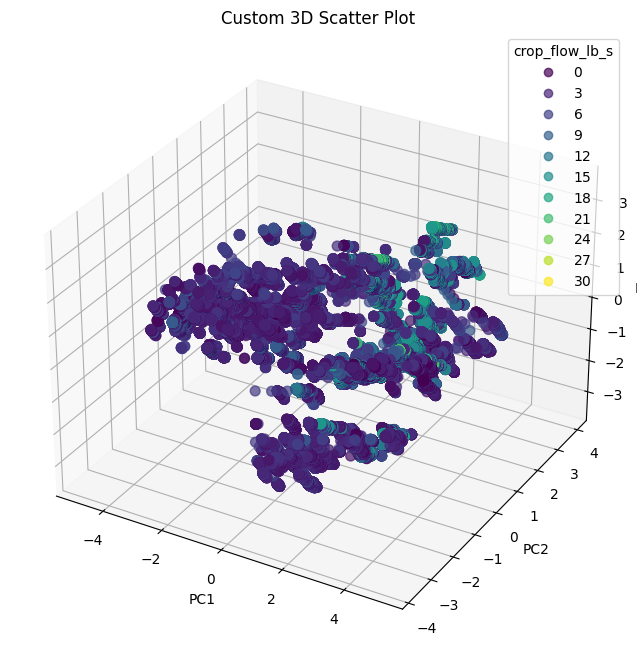

In [ ]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color-coded points based on the number of cylinders
scatter = ax.scatter(transformed_pc['PC1'], transformed_pc['PC2'], transformed_pc['PC3'], c=transformed_pc['crop_flow_lb_s'], cmap='viridis', s=50, alpha=0.7)

# Customize the plot appearance
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Custom 3D Scatter Plot')
ax.legend(*scatter.legend_elements(), title='crop_flow_lb_s')

# Show the plot
plt.show()

In [ ]:
transformed_pc['datetime'] = pd.to_datetime(transformed_pc['datetime'])
transformed_pc['month'] = transformed_pc['datetime'].dt.month
transformed_pc['year'] = transformed_pc['datetime'].dt.year

In [ ]:
transformed_pc

crop_flow_lb_s            datetime          field      city_name  \
0                 0.00 2009-10-16 14:00:00  F1: T2R2-West  Ross Township   
1                 4.80 2009-10-16 14:00:00  F1: T2R2-West  Ross Township   
2                 4.68 2009-10-16 14:00:00  F1: T2R5-West  Ross Township   
3                 3.98 2009-10-16 14:00:00  F1: T2R5-West  Ross Township   
4                 2.98 2009-10-16 14:00:00  F1: T2R5-West  Ross Township   
...                ...                 ...            ...            ...   
350440           10.60 2007-07-09 18:00:00  F1: T2R2-East  Ross Township   
350441            9.90 2007-07-09 18:00:00  F1: T2R2-East  Ross Township   
350442           10.40 2007-07-09 18:00:00  F1: T2R2-East  Ross Township   
350443            9.70 2007-07-09 18:00:00  F1: T2R2-East  Ross Township   
350444            9.80 2007-07-09 18:00:00  F1: T2R2-East  Ross Township   

        product_Corn  product_Soybeans  product_Wheat       PC1       PC2  \
0                  0                 1              0  3.781658  1.597206   
1                  0                 1              0  3.713158  1.502763   
2                  0                 1              0  3.872774  1.673078   
3                  0                 1              0  3.875117  1.675503   
4                  0                 1              0  3.894926  1.694252   
...              ...               ...            ...       ...       ...   
350440             0                 0              1 -4.100974 -0.358484   
350441             0                 0              1 -4.100974 -0.358484   
350442             0                 0              1 -4.100974 -0.358484   
350443             0                 0              1 -4.100974 -0.358484   
350444             0                 0              1 -4.098632 -0.356059   

             PC3       PC4       PC5       PC6       PC7  month  year  
0      -0.231569  0.327539 -0.422582  0.499634 -0.862528     10  2009  
1      -0.156346  0.495098 -0.623663  0.532004 -0.868154     10  2009  
2      -0.514877  0.147105 -0.545803  1.158249 -0.604078     10  2009  
3      -0.520415  0.142061 -0.545247  1.168495 -0.599825     10  2009  
4      -0.573709  0.100911 -0.554342  1.279905 -0.555002     10  2009  
...          ...       ...       ...       ...       ...    ...   ...  
350440  0.172790 -0.145473  0.453026  0.124937 -0.427422      7  2007  
350441  0.172790 -0.145473  0.453026  0.124937 -0.427422      7  2007  
350442  0.172790 -0.145473  0.453026  0.124937 -0.427422      7  2007  
350443  0.172790 -0.145473  0.453026  0.124937 -0.427422      7  2007  
350444  0.167252 -0.150516  0.453582  0.135182 -0.423169      7  2007  

[350445 rows x 16 columns]

In [ ]:
# Pivot the dataset for creating a heatmap
flights_pivot = transformed_pc.pivot_table(index='month', columns='year', values='crop_flow_lb_s')

In [ ]:
from matplotlib.animation import FuncAnimation

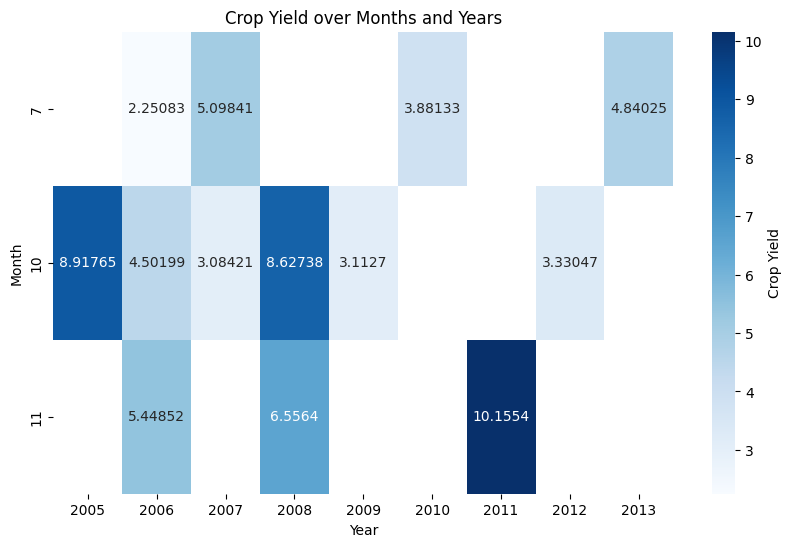

In [ ]:
# Create an animated heatmap
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(flights_pivot, annot=True, fmt='g', cmap='Blues', cbar_kws={'label': 'Crop Yield'})

# Customize the plot appearance
plt.title('Crop Yield over Months and Years')
plt.xlabel('Year')
plt.ylabel('Month')

# Animation function to update the plot
def update(frame):
    ax.clear()
    subset = transformed_pc[transformed_pc['year'] <= frame]
    flights_pivot = subset.pivot_table(index='month', columns='year', values='crop_flow_lb_s')
    sns.heatmap(flights_pivot, annot=True, fmt='g', cmap='Blues', cbar_kws={'label': 'Crop Yield'})
    plt.title(f'Crop Yield over Months and Years (Year {frame})')
    plt.xlabel('Year')
    plt.ylabel('Month')

# Create an animation
animation = FuncAnimation(fig, update, frames=transformed_pc['year'].unique(), repeat=False)

# Show the animation
plt.show()

In [ ]:
transformed_pc

crop_flow_lb_s          field      city_name  \
datetime                                                            
2009-10-16 14:00:00            0.00  F1: T2R2-West  Ross Township   
2009-10-16 14:00:00            4.80  F1: T2R2-West  Ross Township   
2009-10-16 14:00:00            4.68  F1: T2R5-West  Ross Township   
2009-10-16 14:00:00            3.98  F1: T2R5-West  Ross Township   
2009-10-16 14:00:00            2.98  F1: T2R5-West  Ross Township   
...                             ...            ...            ...   
2007-07-09 18:00:00           10.60  F1: T2R2-East  Ross Township   
2007-07-09 18:00:00            9.90  F1: T2R2-East  Ross Township   
2007-07-09 18:00:00           10.40  F1: T2R2-East  Ross Township   
2007-07-09 18:00:00            9.70  F1: T2R2-East  Ross Township   
2007-07-09 18:00:00            9.80  F1: T2R2-East  Ross Township   

                     product_Corn  product_Soybeans  product_Wheat       PC1  \
datetime                                                                       
2009-10-16 14:00:00             0                 1              0  3.781658   
2009-10-16 14:00:00             0                 1              0  3.713158   
2009-10-16 14:00:00             0                 1              0  3.872774   
2009-10-16 14:00:00             0                 1              0  3.875117   
2009-10-16 14:00:00             0                 1              0  3.894926   
...                           ...               ...            ...       ...   
2007-07-09 18:00:00             0                 0              1 -4.100974   
2007-07-09 18:00:00             0                 0              1 -4.100974   
2007-07-09 18:00:00             0                 0              1 -4.100974   
2007-07-09 18:00:00             0                 0              1 -4.100974   
2007-07-09 18:00:00             0                 0              1 -4.098632   

                          PC2       PC3       PC4       PC5       PC6  \
datetime                                                                
2009-10-16 14:00:00  1.597206 -0.231569  0.327539 -0.422582  0.499634   
2009-10-16 14:00:00  1.502763 -0.156346  0.495098 -0.623663  0.532004   
2009-10-16 14:00:00  1.673078 -0.514877  0.147105 -0.545803  1.158249   
2009-10-16 14:00:00  1.675503 -0.520415  0.142061 -0.545247  1.168495   
2009-10-16 14:00:00  1.694252 -0.573709  0.100911 -0.554342  1.279905   
...                       ...       ...       ...       ...       ...   
2007-07-09 18:00:00 -0.358484  0.172790 -0.145473  0.453026  0.124937   
2007-07-09 18:00:00 -0.358484  0.172790 -0.145473  0.453026  0.124937   
2007-07-09 18:00:00 -0.358484  0.172790 -0.145473  0.453026  0.124937   
2007-07-09 18:00:00 -0.358484  0.172790 -0.145473  0.453026  0.124937   
2007-07-09 18:00:00 -0.356059  0.167252 -0.150516  0.453582  0.135182   

                          PC7  month  year  
datetime                                    
2009-10-16 14:00:00 -0.862528     10  2009  
2009-10-16 14:00:00 -0.868154     10  2009  
2009-10-16 14:00:00 -0.604078     10  2009  
2009-10-16 14:00:00 -0.599825     10  2009  
2009-10-16 14:00:00 -0.555002     10  2009  
...                       ...    ...   ...  
2007-07-09 18:00:00 -0.427422      7  2007  
2007-07-09 18:00:00 -0.427422      7  2007  
2007-07-09 18:00:00 -0.427422      7  2007  
2007-07-09 18:00:00 -0.427422      7  2007  
2007-07-09 18:00:00 -0.423169      7  2007  

[350445 rows x 15 columns]

/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


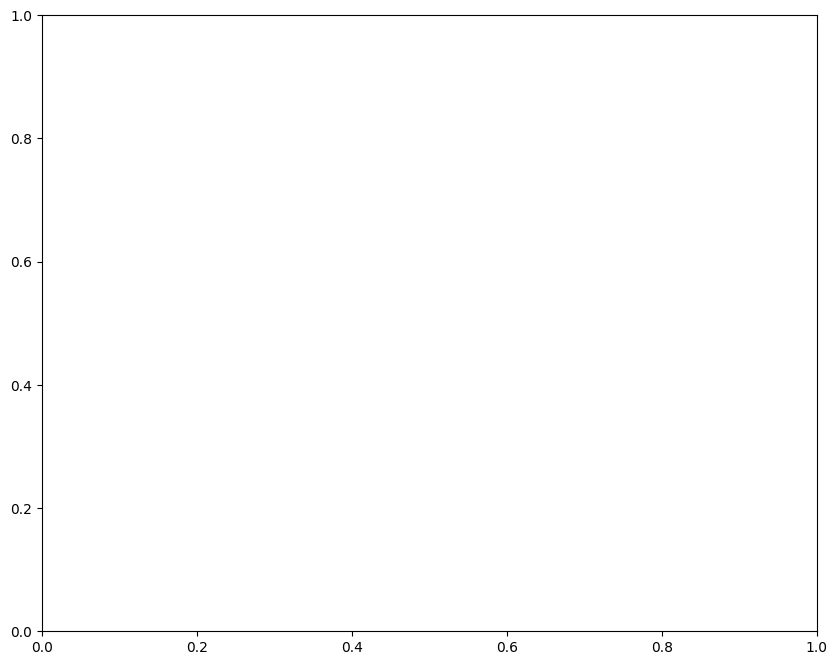

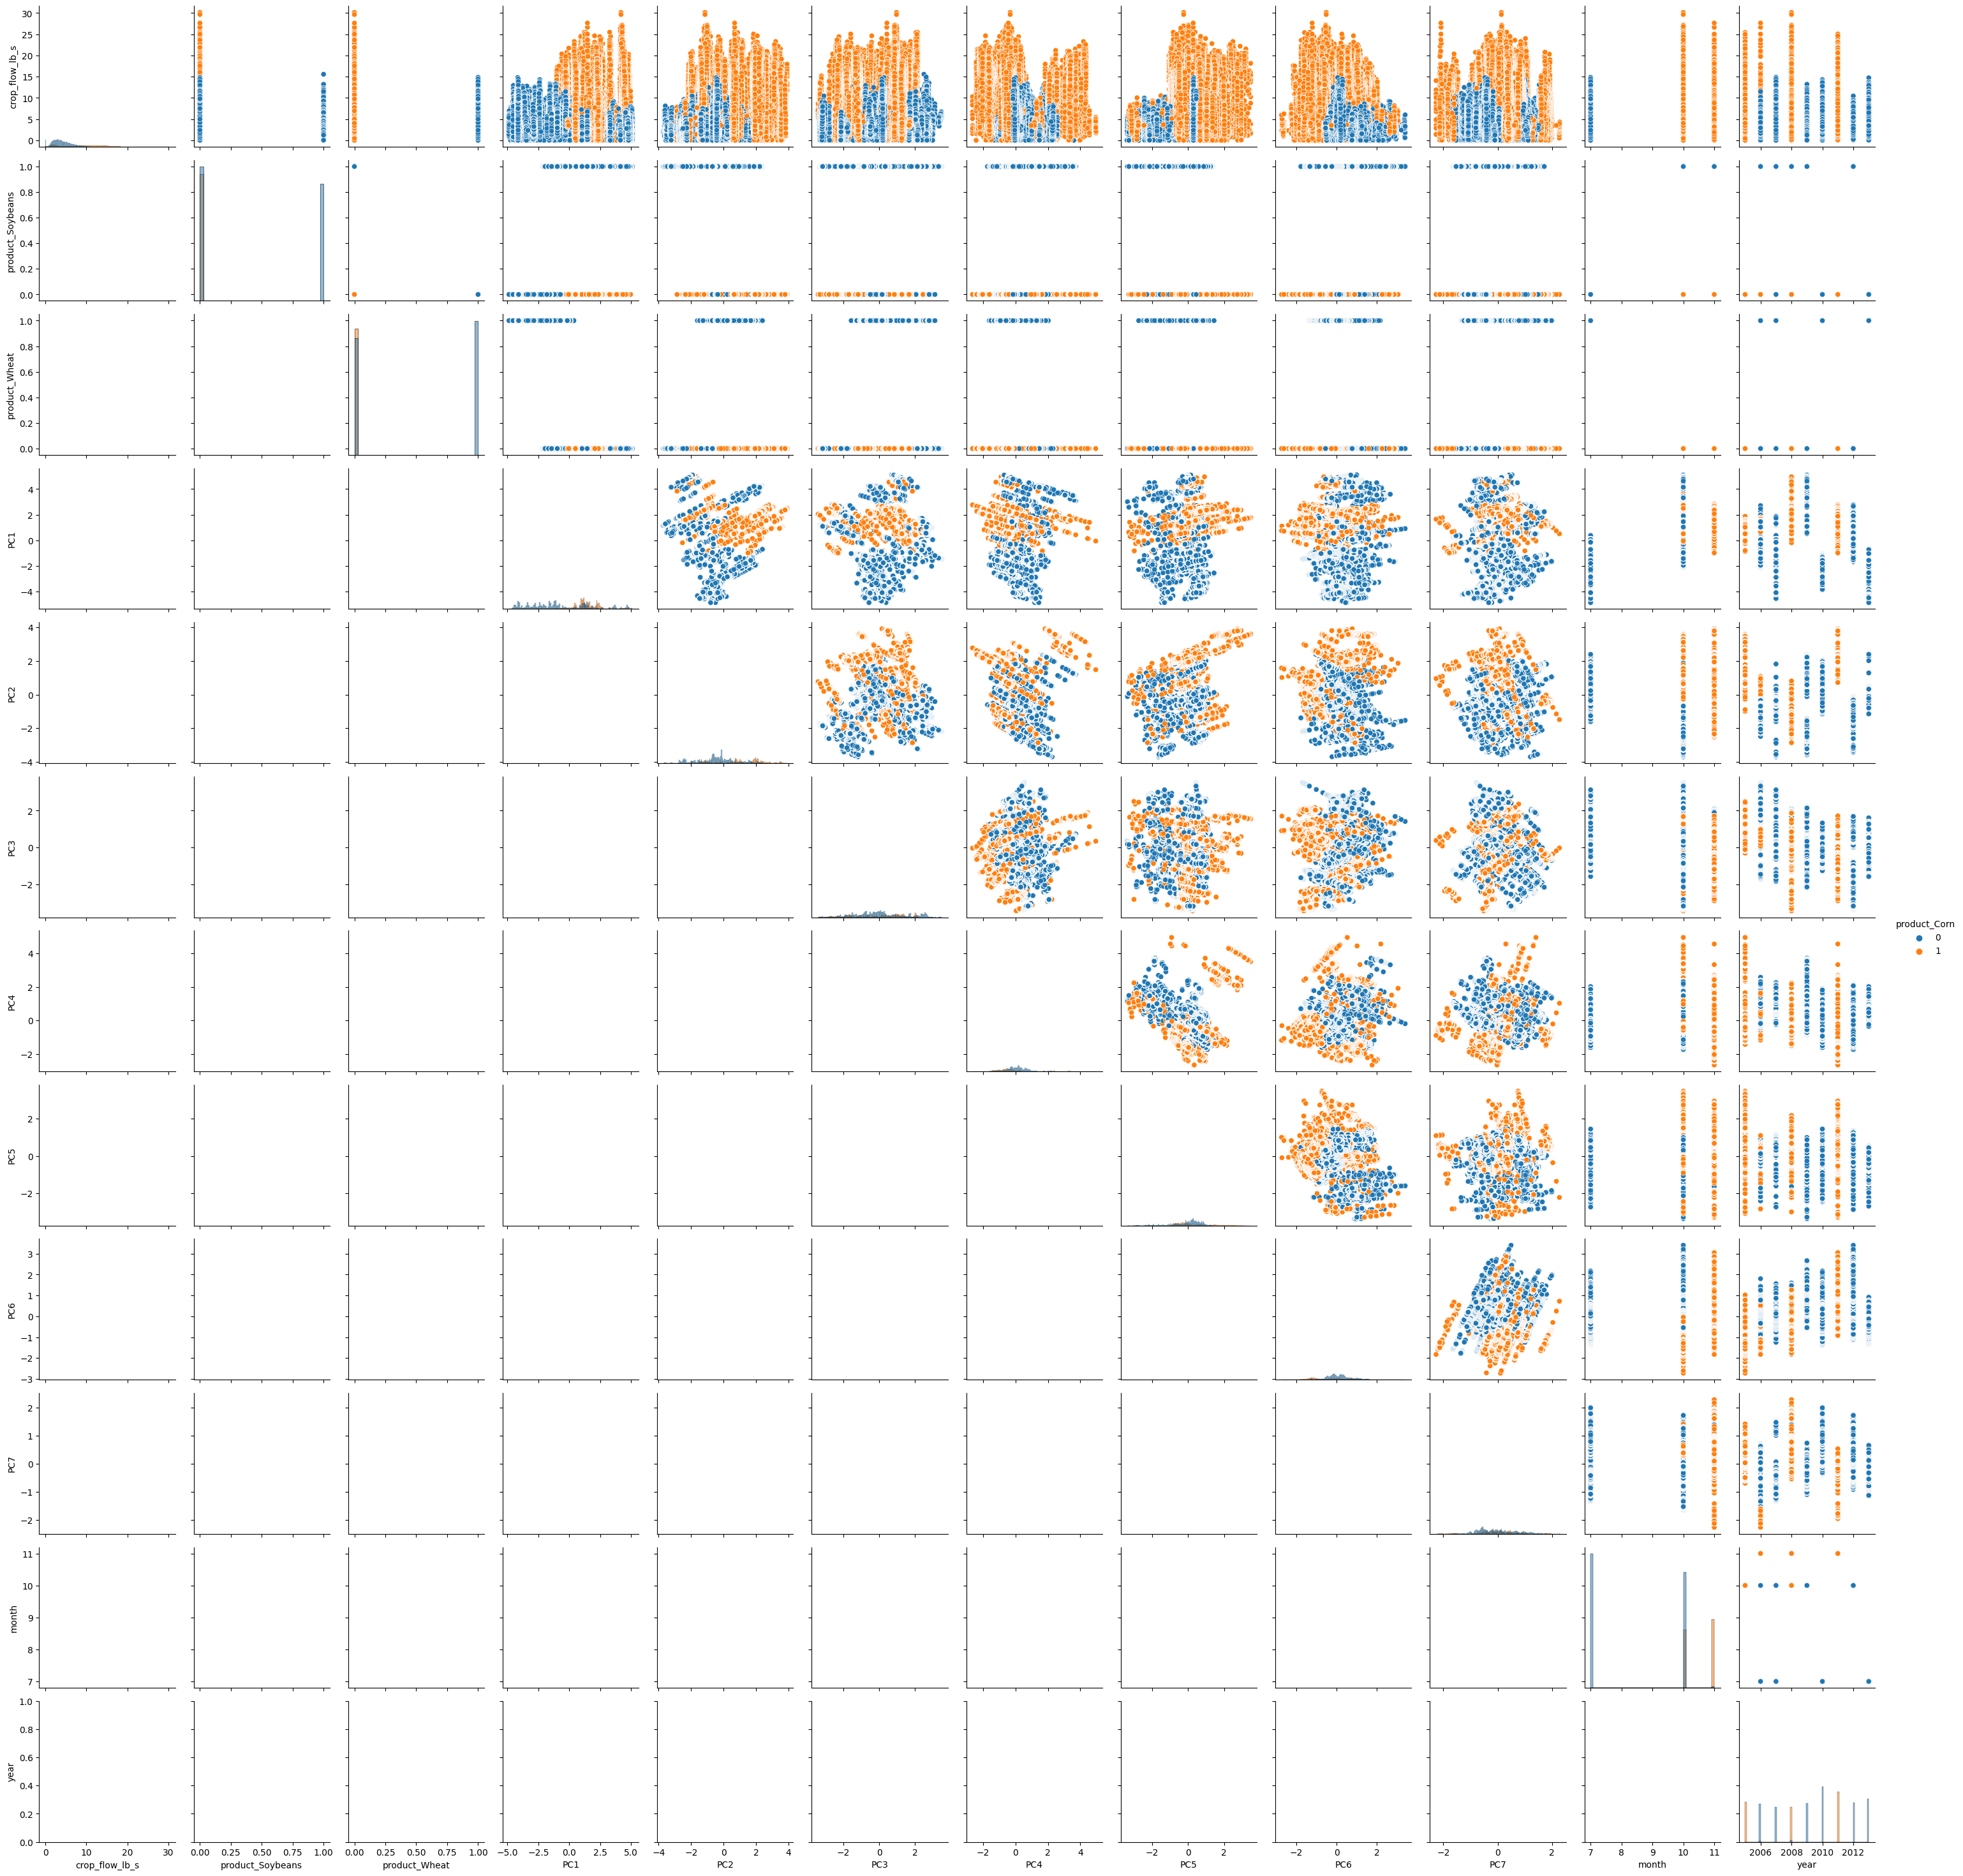

In [ ]:

fig, ax = plt.subplots(figsize=(10, 8))
g = sns.PairGrid(transformed_pc, hue='product_Corn')
g.map_upper(sns.scatterplot)
g.map_diag(sns.histplot)
g.add_legend()

# Animation function to update the plot
def update(frame):
    df_sample = transformed_pc.sample(frac=0.5)
    g.data = df_sample
    return g

# Create an animation
animation = FuncAnimation(fig, update, frames=range(100), interval=50)

# Show the animation
plt.show()


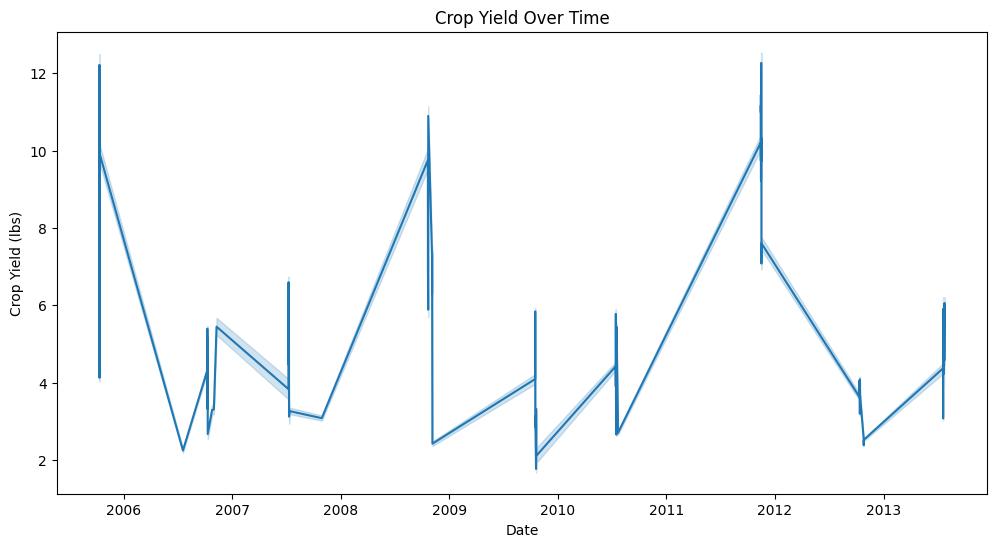

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Assuming 'datetime' is already in datetime format, otherwise convert it
transformed_pc['datetime'] = pd.to_datetime(transformed_pc['datetime'])

plt.figure(figsize=(12, 6))
sns.lineplot(x='datetime', y='crop_flow_lb_s', data=transformed_pc)
plt.title('Crop Yield Over Time')
plt.xlabel('Date')
plt.ylabel('Crop Yield (lbs)')
plt.show()

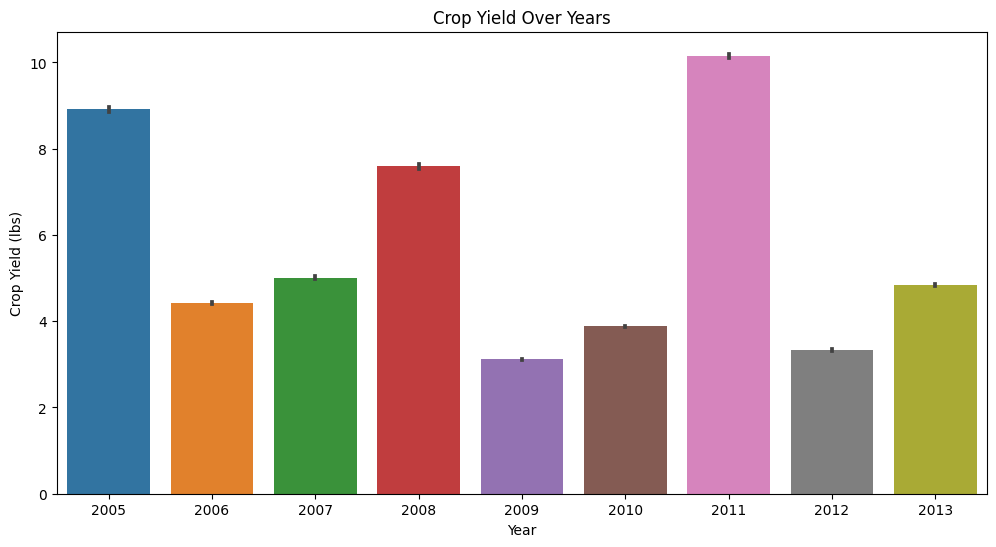

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Assuming 'datetime' is already in datetime format, otherwise convert it
# transformed_pc['datetime'] = pd.to_datetime(transformed_pc['datetime'])

plt.figure(figsize=(12, 6))
sns.barplot(x='year', y='crop_flow_lb_s', data=transformed_pc)
plt.title('Crop Yield Over Years')
plt.xlabel('Year')
plt.ylabel('Crop Yield (lbs)')
plt.show()

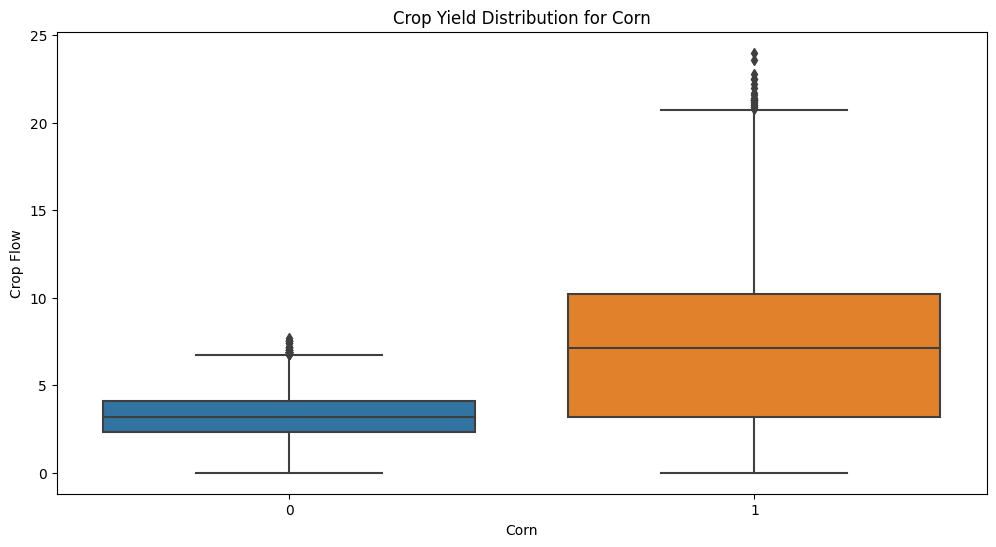

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='product_Corn', y='crop_flow_lb_s', data=transformed_pc[:10000])
plt.title('Crop Yield Distribution for Corn')
plt.xlabel('Corn')
plt.ylabel('Crop Flow')
plt.show()


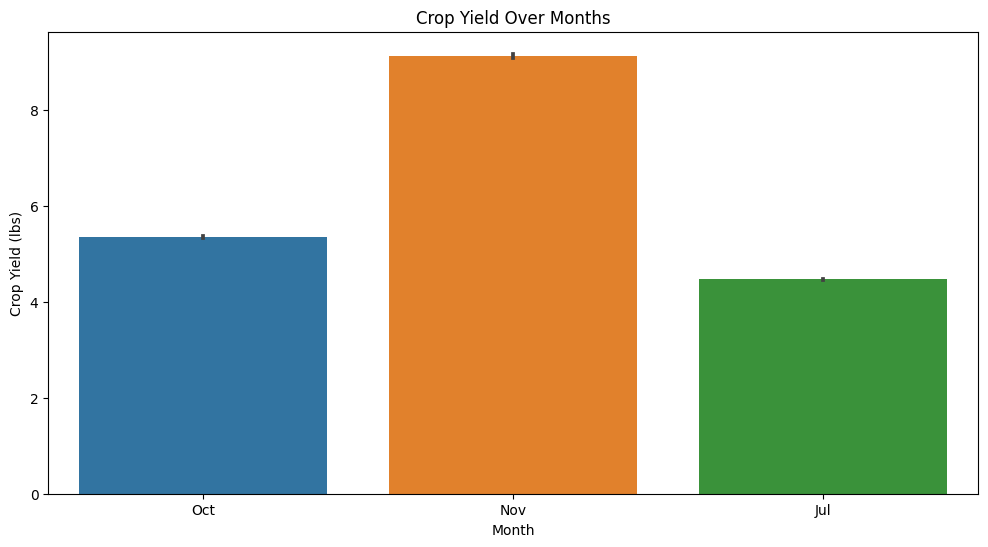

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Assuming 'datetime' is already in datetime format, otherwise convert it
# transformed_pc['datetime'] = pd.to_datetime(transformed_pc['datetime'])
months_dict = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sept',10:'Oct',11:'Nov',12:'Dec'}

transformed_pc['month_name'] = transformed_pc['month'].map(months_dict)

plt.figure(figsize=(12, 6))
sns.barplot(x='month_name', y='crop_flow_lb_s', data=transformed_pc)
plt.title('Crop Yield Over Months')
plt.xlabel('Month')
plt.ylabel('Crop Yield (lbs)')
plt.show()

In [ ]:
import plotly.express as px


frames = []

for _ in range(100):
    df_sample = transformed_pc.sample(frac=0.5)
    frames.append(df_sample)

# Create the animated figure
animated_fig = px.scatter_3d(frames, x='PC4', y='PC5', z='PC6', animation_frame=transformed_pc.index, range_x=[-10, 10], range_y=[-10, 10], range_z=[-10, 10])

# Show the animated figure
animated_fig.show()


In [ ]:
from google.colab import files

In [ ]:
transformed_pc.to_csv('transformed_pc.csv')
files.download('transformed_pc.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Loading the transformed data for modeling**

In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Load transformed dataset - Pulling from the shared drive
transformed = pd.read_csv('/content/drive/Shareddrives/GWAR_datasets/transformed_pc.csv')
del transformed[transformed.columns[0]]
transformed

crop_flow_lb_s             datetime          field      city_name  \
0                 0.00  2009-10-16 14:00:00  F1: T2R2-West  Ross Township   
1                 4.80  2009-10-16 14:00:00  F1: T2R2-West  Ross Township   
2                 4.68  2009-10-16 14:00:00  F1: T2R5-West  Ross Township   
3                 3.98  2009-10-16 14:00:00  F1: T2R5-West  Ross Township   
4                 2.98  2009-10-16 14:00:00  F1: T2R5-West  Ross Township   
...                ...                  ...            ...            ...   
350440           10.60  2007-07-09 18:00:00  F1: T2R2-East  Ross Township   
350441            9.90  2007-07-09 18:00:00  F1: T2R2-East  Ross Township   
350442           10.40  2007-07-09 18:00:00  F1: T2R2-East  Ross Township   
350443            9.70  2007-07-09 18:00:00  F1: T2R2-East  Ross Township   
350444            9.80  2007-07-09 18:00:00  F1: T2R2-East  Ross Township   

        product_Corn  product_Soybeans  product_Wheat       PC1       PC2  \
0                  0                 1              0  3.781658  1.597206   
1                  0                 1              0  3.713158  1.502763   
2                  0                 1              0  3.872774  1.673078   
3                  0                 1              0  3.875117  1.675503   
4                  0                 1              0  3.894926  1.694252   
...              ...               ...            ...       ...       ...   
350440             0                 0              1 -4.100974 -0.358484   
350441             0                 0              1 -4.100974 -0.358484   
350442             0                 0              1 -4.100974 -0.358484   
350443             0                 0              1 -4.100974 -0.358484   
350444             0                 0              1 -4.098632 -0.356059   

             PC3       PC4       PC5       PC6       PC7  month  year  
0      -0.231569  0.327539 -0.422582  0.499634 -0.862528     10  2009  
1      -0.156346  0.495098 -0.623663  0.532004 -0.868154     10  2009  
2      -0.514877  0.147105 -0.545803  1.158249 -0.604078     10  2009  
3      -0.520415  0.142061 -0.545247  1.168495 -0.599825     10  2009  
4      -0.573709  0.100911 -0.554342  1.279905 -0.555002     10  2009  
...          ...       ...       ...       ...       ...    ...   ...  
350440  0.172790 -0.145473  0.453026  0.124937 -0.427422      7  2007  
350441  0.172790 -0.145473  0.453026  0.124937 -0.427422      7  2007  
350442  0.172790 -0.145473  0.453026  0.124937 -0.427422      7  2007  
350443  0.172790 -0.145473  0.453026  0.124937 -0.427422      7  2007  
350444  0.167252 -0.150516  0.453582  0.135182 -0.423169      7  2007  

[350445 rows x 16 columns]

In [ ]:
!pip install fast_ml --quiet

In [ ]:
from fast_ml.model_development import train_valid_test_split

In [ ]:
#train, validation, and test data split
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(transformed, target = 'crop_flow_lb_s', train_size=0.8, valid_size=0.1, test_size=0.1)

In [ ]:
print('Training dataset:   ',X_train.shape, y_train.shape )
print('Validation dataset: ',X_valid.shape, y_valid.shape )
print('Test dataset:       ',X_test.shape, y_test.shape )

Training dataset:    (280356, 15) (280356,)
Validation dataset:  (35044, 15) (35044,)
Test dataset:        (35045, 15) (35045,)


In [ ]:
X_train

datetime          field      city_name  product_Corn  \
311068  2007-07-10 14:00:00  F1: T4R2-West  Ross Township             0   
40599   2012-10-25 16:00:00  F1: T4R3-West  Ross Township             0   
340519  2006-10-10 15:00:00  F1: T4R2-East  Ross Township             0   
325131  2007-07-10 18:00:00  F1: T4R5-West  Ross Township             0   
308386  2009-10-19 17:00:00  F1: T4R2-East  Ross Township             0   
...                     ...            ...            ...           ...   
66821   2010-07-14 19:00:00  F1: T1R2-East  Ross Township             0   
13051   2013-07-19 20:00:00  F1: T1R6-East  Ross Township             0   
242496  2005-10-11 16:00:00  F1: T4R4-West  Ross Township             1   
62294   2009-10-19 14:00:00  F1: T2R6-East  Ross Township             0   
277391  2011-11-14 12:00:00  F1: T1R1-West  Ross Township             1   

        product_Soybeans  product_Wheat       PC1       PC2       PC3  \
311068                 0              1 -2.396289 -0.695222  1.677529   
40599                  1              0 -1.226753 -1.050898  0.709754   
340519                 1              0 -0.321877 -0.623235  2.137670   
325131                 0              1 -4.121123 -0.821066 -0.513434   
308386                 1              0  1.104464 -2.404117 -2.198701   
...                  ...            ...       ...       ...       ...   
66821                  0              1 -2.888473 -0.518072  0.033083   
13051                  0              1 -4.347544 -0.324100 -0.133434   
242496                 0              0  0.408714  1.068943  1.110070   
62294                  1              0  3.078624 -2.667475  1.411510   
277391                 0              0  0.846604  1.979431 -1.695064   

             PC4       PC5       PC6       PC7  month  year  
311068 -0.274363  0.698473  0.252343 -0.773877      7  2007  
40599  -1.110162  1.234402  0.964985 -0.169472     10  2012  
340519 -0.296285 -0.140407 -0.215841 -0.240718     10  2006  
325131  0.152344  0.682319  0.196174 -1.082040      7  2007  
308386  0.264339  0.883678  0.391356 -0.553250     10  2009  
...          ...       ...       ...       ...    ...   ...  
66821  -0.601823  0.349704  1.008217  0.569300      7  2010  
13051   0.239747  0.216045 -0.210163 -0.476789      7  2013  
242496 -0.309252 -0.359367 -1.906105  0.314164     10  2005  
62294   0.874558 -1.967356  1.876746  0.105334     10  2009  
277391 -0.956214 -0.445333  0.531686 -0.652680     11  2011  

[280356 rows x 15 columns]

In [ ]:
y_train

311068    4.64
40599     2.47
340519    6.86
325131    2.58
308386    4.15
          ... 
66821     5.11
13051     2.56
242496    5.10
62294     3.00
277391    8.32
Name: crop_flow_lb_s, Length: 280356, dtype: float64

In [ ]:
from sklearn.preprocessing import LabelEncoder
#Pre-processing
transformed['datetime'] = pd.to_datetime(transformed['datetime'])
transformed['datetime'] = transformed['datetime'].astype(int) // 10**9  # Convert to seconds


#drop city_name since it is the same city
transformed = transformed.drop(columns=['city_name'])
# Assuming 'string_column' is the name of your string column
label_encoder = LabelEncoder()
transformed['field'] = label_encoder.fit_transform(transformed['field'])
# Save the encoding information for later use
encoding_info = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Now, you can use encoding_info to map codes back to original values
print(encoding_info)


{'F1: Biodiversity Plots': 0, 'F1: Lysimeter': 1, 'F1: T1R1-East': 2, 'F1: T1R1-West': 3, 'F1: T1R2-East': 4, 'F1: T1R2-West': 5, 'F1: T1R3-East': 6, 'F1: T1R3-West': 7, 'F1: T1R4-East': 8, 'F1: T1R4-West': 9, 'F1: T1R5-East': 10, 'F1: T1R5-West': 11, 'F1: T1R6-East': 12, 'F1: T1R6-West': 13, 'F1: T2R1-East': 14, 'F1: T2R1-West': 15, 'F1: T2R2-East': 16, 'F1: T2R2-West': 17, 'F1: T2R3-East': 18, 'F1: T2R3-West': 19, 'F1: T2R4-East': 20, 'F1: T2R4-West': 21, 'F1: T2R5-East': 22, 'F1: T2R5-West': 23, 'F1: T2R6-East': 24, 'F1: T2R6-West': 25, 'F1: T3R1-East': 26, 'F1: T3R1-West': 27, 'F1: T3R2-East': 28, 'F1: T3R2-West': 29, 'F1: T3R3-East': 30, 'F1: T3R3-West': 31, 'F1: T3R4-East': 32, 'F1: T3R4-West': 33, 'F1: T3R5-East': 34, 'F1: T3R5-West': 35, 'F1: T3R6-East': 36, 'F1: T3R6-West': 37, 'F1: T4R1-East': 38, 'F1: T4R1-West': 39, 'F1: T4R2-East': 40, 'F1: T4R2-West': 41, 'F1: T4R3-East': 42, 'F1: T4R3-West': 43, 'F1: T4R4-East': 44, 'F1: T4R4-West': 45, 'F1: T4R5-East': 46, 'F1: T4R5-Wes

In [ ]:
transformed

crop_flow_lb_s    datetime  field  product_Corn  product_Soybeans  \
0                 0.00  1255701600     17             0                 1   
1                 4.80  1255701600     17             0                 1   
2                 4.68  1255701600     23             0                 1   
3                 3.98  1255701600     23             0                 1   
4                 2.98  1255701600     23             0                 1   
...                ...         ...    ...           ...               ...   
350440           10.60  1184004000     16             0                 0   
350441            9.90  1184004000     16             0                 0   
350442           10.40  1184004000     16             0                 0   
350443            9.70  1184004000     16             0                 0   
350444            9.80  1184004000     16             0                 0   

        product_Wheat       PC1       PC2       PC3       PC4       PC5  \
0                   0  3.781658  1.597206 -0.231569  0.327539 -0.422582   
1                   0  3.713158  1.502763 -0.156346  0.495098 -0.623663   
2                   0  3.872774  1.673078 -0.514877  0.147105 -0.545803   
3                   0  3.875117  1.675503 -0.520415  0.142061 -0.545247   
4                   0  3.894926  1.694252 -0.573709  0.100911 -0.554342   
...               ...       ...       ...       ...       ...       ...   
350440              1 -4.100974 -0.358484  0.172790 -0.145473  0.453026   
350441              1 -4.100974 -0.358484  0.172790 -0.145473  0.453026   
350442              1 -4.100974 -0.358484  0.172790 -0.145473  0.453026   
350443              1 -4.100974 -0.358484  0.172790 -0.145473  0.453026   
350444              1 -4.098632 -0.356059  0.167252 -0.150516  0.453582   

             PC6       PC7  month  year  
0       0.499634 -0.862528     10  2009  
1       0.532004 -0.868154     10  2009  
2       1.158249 -0.604078     10  2009  
3       1.168495 -0.599825     10  2009  
4       1.279905 -0.555002     10  2009  
...          ...       ...    ...   ...  
350440  0.124937 -0.427422      7  2007  
350441  0.124937 -0.427422      7  2007  
350442  0.124937 -0.427422      7  2007  
350443  0.124937 -0.427422      7  2007  
350444  0.135182 -0.423169      7  2007  

[350445 rows x 15 columns]

In [ ]:
transformed.to_csv('transformed_new.csv')
files.download('transformed_new.csv')